In [56]:
import numpy as np
import tensorflow as tf
import random
import math
from pathlib import Path

from psychrnn.backend.models.basic import Basic
from single_mixed_classes import mixedBrainRegionsRNN
# from mixed_classes_restricted_input import mixedBrainRegionsRNN
from classes import MyBumpBasic
from model_utils import TargetDistractor, get_bump_attractor_weights, create_model_dataset, get_correct_trials, performance_measure
from analysis_utils import get_neuron_selectivity, get_trialwise_mean, split_train_test, find_selective_locations, find_non_selective_locations, zscore_dataset 

from matplotlib import pyplot as plt
# plt.style.use('classic')
import itertools
from collections import defaultdict 
from scipy import stats
from itertools import combinations
import sys
import pickle
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import json


In [2]:
# Method to check the model performance
# Initialized here to be able to be called within notebook
def performance_measure(trial_batch, trial_y, output_mask, output, epoch, losses, verbosity):
    """
    Function that calculates the performance of the model on the given trial batch and the output of the model
    *task should be initialized beforehand
    """
    return drt.accuracy_function(trial_y, output, output_mask)

In [3]:
# Task parameters
inputs = 4 # Number of input channels (Target stimulus)
outputs = 4 # Number of output channels (Model responses)

N_batch = 20 # The number of trials per training update.
negative_weights = True # to use negative weights in the 

# Bump attractor model parameters
bump_kappa = 3 # kappa parameter, setting the width of the bump
n_in_bump=11 # set the number of neurons in each bump group

bump_overlap = n_in_bump-2#int(n_in_bump/5) # set the overlap between the bump groups
bump_population=bump_overlap*int(inputs) # number of bump neurons in the mixed population


In [4]:
bump_population

36

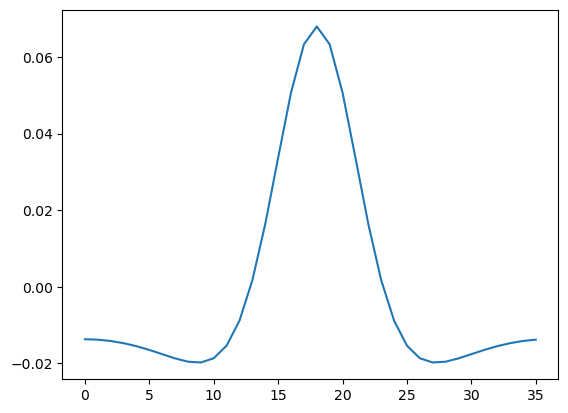

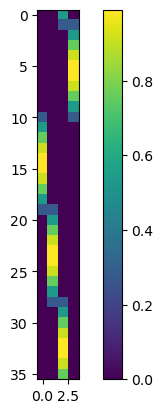

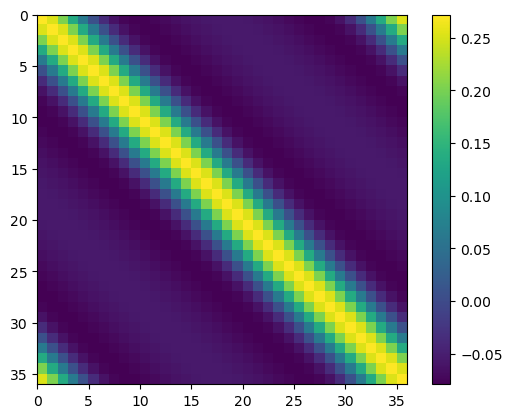

In [5]:
bump_w, bump_w_in, _ = get_bump_attractor_weights(bump_population, inputs, kappa=bump_kappa,
                                                  population_size=1,
                                                  population_overlap=1, negative_w=negative_weights, groupsize=n_in_bump,
                                                  ordered=True, bump_overlap=bump_overlap)
# plot bump shape
plt.plot(bump_w[int(bump_population/2)])

plt.show()

# plot input and recurrent weights of the bump neurons 
plt.imshow(bump_w_in)
plt.colorbar()
plt.show()
plt.imshow(bump_w*4,  extent=[0,bump_population,bump_population,0])

plt.colorbar()
plt.show()


In [6]:
np.where(bump_w[int(bump_population/2)]>0)[0].shape

(11,)

In [7]:
# # Ranging Parameters
max_iters = 200000
model_version_range = np.arange(1) # number of model versions
monkey_session_data = np.load('saved_results/'+'monkey_session_selectivity_trial_data.npy', allow_pickle=True).item()

tau_range =[200] # The intrinsic time constant of neural state decay.
dt_percentage = {200:1/4, 250:1/5, 20:1/4, 50:1/5, 20:1/4, 40:1/4} # The simulation timestep. Can vary between 1/4 and 1/5 of the tau parameter 


input_sigma_range = [0.01] # Noise applied to the input signal
recurrent_noise_range =[0.08]#[0.07, 0.08, 0.09] # Independent recurrent noise for each neuronal cell

# Connection percentages between bump and non-bump regions
inner_connect_percen_range = [0.05]
# Connection percentages between 
inter_connect_percen_range = [0]

# Percentage of connections to the downstream output layer
output_projection_percentage = 0.8

bump_percen_range = [0.2]#[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8 ,0.9, 1]

# folder to save the model data
data_folder_list = ['datasets']
data_folder='datasets'
bump_rec_strength = 1


In [8]:
data_folder_list

['datasets']

In [9]:
bump_percen_range

[0.2]

# Save weights

In [10]:
for bump_percen in bump_percen_range:
    # pick a different performance counter limit since the models with higher bump percentage need more training
    # to reach the 70% task accuracy performance of the monkeys.
    if bump_percen >= 0.9:
        performance_counter_max = 11
    elif bump_percen >= 0.7:
        performance_counter_max = 9
    elif bump_percen >= 0.5:
        performance_counter_max = 7
    elif bump_percen > 0.25:
        performance_counter_max = 6
    else:
        performance_counter_max = 5

    if bump_percen == 0:
        N_rec1 = bump_population
    elif bump_percen == 1:
        N_rec1 = bump_population
    else:
        N_rec1 = int(bump_population/bump_percen) # Number of neurons for region1 
        non_bump_population = N_rec1-bump_population # number of non-bump neurons in region1
    for tau in tau_range:
        dt = int(tau*dt_percentage[tau])#int(tau/5)
        for input_sigma in input_sigma_range:
            for recurrent_noise in recurrent_noise_range:
                for inter_connect_percen in inter_connect_percen_range:
                    for inner_connect_percen in inner_connect_percen_range:
                        params_values = '/stimulus'+str(outputs)+'/dt'+str(dt)+'/tau'+str(tau)+'/input-noise'+str(input_sigma)+'/rec-noise'+str(recurrent_noise)+'/inter-connect'+str(inter_connect_percen)+'/inner-connect'+str(inner_connect_percen)+'/'

                        print(params_values)
                        Path(data_folder+params_values).mkdir(parents=True, exist_ok=True)
                        for model_version in model_version_range:
                            seed=model_version*20+1
                            tf.compat.v2.random.set_seed(seed)
                            random.seed(seed)
                            np.random.seed(seed)

                            drt = TargetDistractor(N_inputs = inputs, N_outputs=outputs, dt= dt, tau=tau, T=dt*58,
                                                            cue_start=dt*2, cue_end=dt*8, dis_start=dt*28, dis_end=dt*34, decision_start=dt*54,
                                                            N_batch = N_batch,
                                                            sigma=input_sigma)

                            network_params = drt.get_task_params()
                            # name of the model
                            name = 'bump'+str(bump_percen)+"_"+str(N_rec1)+'Nrec_' #  Unique name used to determine variable scope for internal use.        

                            # add the session number in the model name
                            name = name+str(model_version)
                            print("\nSeed: ", seed,"\nIteration: ", model_version, "\nModel name: ", name)

                            key_name = params_values+name
                            print(key_name)

                            train_params = {}
                            train_params['save_weights_path'] = data_folder+key_name+'_weights_epoch'
                            train_params['performance_counter_max'] = performance_counter_max
                            # set model name
                            network_params['name'] = name # Unique name used to determine variable scope.
                            network_params['transfer_function'] = tf.nn.relu
                            if bump_percen ==0:
                                network_params['N_rec'] = N_rec1
                                network_params['rec_noise'] = recurrent_noise
                                # No input weight training
                                network_params['W_in_train'] = False
                                # Training of recurrent weights
                                network_params['W_rec_train'] = True

                                network_params['W_in'] = np.random.normal(0, np.sqrt(2/(N_rec1+inputs)),
                                                                           size=(N_rec1, inputs))
                                network_params['W_rec'] = np.random.normal(0,
                                                                              np.sqrt(2/(N_rec1+N_rec1)),
                                                                                    size=(N_rec1, N_rec1))
                                network_params['output_connectivity'] = np.random.choice([0, 1],
                                                                                     size=(inputs,non_bump_population),
                                                                                     p=[(1-output_projection_percentage), output_projection_percentage])

                                model = Basic(network_params) # instantiate an RNN

                            elif bump_percen ==1:
                                max_iters = 100000
                                network_params['N_rec'] = N_rec1
                                network_params['rec_noise'] = recurrent_noise
                                # No input weight training
                                network_params['W_in_train'] = False
                                # Training of Recurrent weights
                                network_params['W_rec_train'] = True
                                bump_w, bump_w_in, _ = get_bump_attractor_weights(bump_population, inputs,
                                                                              kappa=bump_kappa, population_size=1, population_overlap=1,
                                                                              negative_w=negative_weights, groupsize=n_in_bump, ordered=True,
                                                                              bump_overlap=bump_overlap)
                                network_params['W_in'] = bump_w_in
                                network_params['W_rec'] = bump_w*bump_rec_strength
                                network_params['output_connectivity'] = np.random.choice([0, 1],
                                                                                     size=(inputs, bump_population),
                                                                                     p=[(1-output_projection_percentage), output_projection_percentage])

                                model = MyBumpBasic(network_params) # instantiate an RNN

                            else:
                                # Set network parameters
                                network_params['rec_noise1'] = recurrent_noise

                                # Set the whole number of neurons (both regions)
                                network_params['N_rec'] = N_rec1
                                # Set the number of neurons for mixed region1
                                network_params['N_rec1_1'] = bump_population
                                network_params['N_rec1_2'] = non_bump_population
                                connectivity1_1 = np.concatenate([np.ones((bump_population,inputs)),
                                                                        np.random.choice([0, 1],
                                                                                         size=(bump_population, non_bump_population),
                                                                                         p=[(1-inner_connect_percen), inner_connect_percen])], axis=1)

                                connectivity1_2 = np.concatenate([np.ones((non_bump_population, inputs)),
                                                                        np.random.choice([0, 1],
                                                                                         size=(non_bump_population, bump_population),
                                                                                         p=[(1-inner_connect_percen), inner_connect_percen]),],axis=1)

                                network_params['input_connectivity1_1'] = connectivity1_1
                                network_params['input_connectivity1_2'] = connectivity1_2
                                
                                bump_w, bump_w_in, _ = get_bump_attractor_weights(bump_population, inputs,
                                                                              kappa=bump_kappa, population_size=1, population_overlap=1,
                                                                              negative_w=negative_weights, groupsize=n_in_bump, ordered=True,
                                                                              bump_overlap=bump_overlap)
                                # set recurrent weights of bump population
                                network_params['W_rec1_1'] = bump_w*bump_rec_strength # increase the power of the recurrent weights of bump neurons
                                # set the rest of recurrent and input weights accoring to xavier2 method
                                network_params['W_rec1_2'] = np.random.normal(0, np.sqrt(2/(non_bump_population+non_bump_population)),
                                                                                    size=(non_bump_population, non_bump_population))

                                # set input weights of the other regions to bump populations according to xavier2
                                non_bump_to_bump_input = np.random.normal(0, np.sqrt(2/(non_bump_population+bump_population)), size=(bump_population, non_bump_population))

                                # concatenate the bump input weights with the input from the other two regions 
                                network_params['W_in1_1'] = np.concatenate([bump_w_in, non_bump_to_bump_input], axis=1)
                                # set the input weights of non bump neurons according to xavier2 method
                                network_params['W_in1_2'] = np.random.normal(0, np.sqrt(2/(non_bump_population+inputs+bump_population)),
                                                                           size=(non_bump_population, inputs+bump_population))

                                W_rec1_1_fixed = np.ones_like(network_params['W_rec1_1'])
                                W_rec1_2_fixed = np.ones_like(network_params['W_rec1_2'])

                                W_in1_1_fixed = np.zeros_like(network_params['W_in1_1'])
                                W_in1_1_fixed[:,:inputs] = 1

                                W_in1_2_fixed = np.zeros_like(network_params['W_in1_2'])
                                W_in1_2_fixed[:,:inputs] = 1
                                # choose to which weights to freeze. Here we freeze all input weights
                                train_params['fixed_weights'] = {
    #                                     'W_rec1_1': W_rec1_1_fixed,
    #                                     'W_rec1_2': W_rec1_2_fixed,
                                    'W_in1_1': W_in1_1_fixed,
                                    'W_in1_2': W_in1_2_fixed
                                }
                                network_params['output_connectivity'] = np.random.choice([0, 1],
                                                                                     size=(inputs, bump_population+non_bump_population),
                                                                                     p=[(1-output_projection_percentage), output_projection_percentage])

                                model = mixedBrainRegionsRNN(network_params) # instantiate an RNN
                            # Save the init weights of the model 
#                             model.save(train_params['save_weights_path']+'0')

                            train_params['performance_measure'] = performance_measure
                            train_params['performance_cutoff'] = 0.7 # The 70% accuracy animals perform
                            train_params['save_training_weights_epoch'] = 1000
                            train_params['training_iters'] = max_iters 

                            train_params['training_weights_path'] = data_folder+key_name+'_weights_epoch'
                            # Train the model
                            losses, initialTime, trainTime = model.train(drt, train_params)
                            # Save the weights of the trained model
                            model.save(train_params['save_weights_path'])

                            model.destruct()

/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/

Seed:  1 
Iteration:  0 
Model name:  bump0.2_180Nrec_0
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_0
performance: 0.35
performance: 0.15
performance: 0.15
performance: 0.25
performance: 0.2
performance: 0.2
performance: 0.2
performance: 0.2
performance: 0.25
Iter 200, Minibatch Loss= 0.010735
performance: 0.1
performance: 0.35
performance: 0.2
performance: 0.15
performance: 0.2
performance: 0.4
performance: 0.4
performance: 0.2
performance: 0.05
performance: 0.3
Iter 400, Minibatch Loss= 0.009765
performance: 0.15
performance: 0.1
performance: 0.25
performance: 0.25
performance: 0.15
performance: 0.35
performance: 0.35
performance: 0.25
performance: 0.25
performance: 0.2
Iter 600, Minibatch Loss= 0.010883
performance: 0.2
performance: 0.3
performance: 0.35
performance: 0.3
performance: 0.2
performance: 0.3
performance: 0.25
performance: 0.3


Iter 7600, Minibatch Loss= 0.010466
performance: 0.15
performance: 0.35
performance: 0.25
performance: 0.25
performance: 0.3
performance: 0.4
performance: 0.25
performance: 0.2
performance: 0.15
performance: 0.2
Iter 7800, Minibatch Loss= 0.009792
performance: 0.3
performance: 0.3
performance: 0.4
performance: 0.15
performance: 0.35
performance: 0.1
performance: 0.2
performance: 0.3
performance: 0.25
performance: 0.35
Iter 8000, Minibatch Loss= 0.009857
performance: 0.35
performance: 0.1
performance: 0.25
performance: 0.25
performance: 0.15
performance: 0.2
performance: 0.3
performance: 0.35
performance: 0.25
performance: 0.2
Iter 8200, Minibatch Loss= 0.009860
performance: 0.65
performance: 0.45
performance: 0.3
performance: 0.3
performance: 0.35
performance: 0.25
performance: 0.25
performance: 0.1
performance: 0.35
performance: 0.25
Iter 8400, Minibatch Loss= 0.009759
performance: 0.15
performance: 0.2
performance: 0.2
performance: 0.35
performance: 0.2
performance: 0.35
performance:

performance: 0.05
performance: 0.25
performance: 0.25
performance: 0.25
performance: 0.2
performance: 0.3
performance: 0.3
performance: 0.3
performance: 0.15
performance: 0.2
Iter 16000, Minibatch Loss= 0.009552
performance: 0.3
performance: 0.35
performance: 0.3
performance: 0.15
performance: 0.25
performance: 0.35
performance: 0.3
performance: 0.2
performance: 0.3
performance: 0.35
Iter 16200, Minibatch Loss= 0.009837
performance: 0.1
performance: 0.35
performance: 0.35
performance: 0.3
performance: 0.25
performance: 0.25
performance: 0.35
performance: 0.1
performance: 0.2
performance: 0.3
Iter 16400, Minibatch Loss= 0.009833
performance: 0.25
performance: 0.3
performance: 0.25
performance: 0.2
performance: 0.25
performance: 0.3
performance: 0.35
performance: 0.2
performance: 0.25
performance: 0.2
Iter 16600, Minibatch Loss= 0.010029
performance: 0.4
performance: 0.25
performance: 0.25
performance: 0.3
performance: 0.2
performance: 0.15
performance: 0.2
performance: 0.35
performance:

performance: 0.25
performance: 0.2
performance: 0.05
performance: 0.15
performance: 0.25
performance: 0.1
performance: 0.2
performance: 0.25
performance: 0.3
performance: 0.15
Iter 23600, Minibatch Loss= 0.009662
performance: 0.45
performance: 0.3
performance: 0.45
performance: 0.25
performance: 0.2
performance: 0.35
performance: 0.25
performance: 0.1
performance: 0.3
performance: 0.25
Iter 23800, Minibatch Loss= 0.009607
performance: 0.3
performance: 0.35
performance: 0.1
performance: 0.45
performance: 0.1
performance: 0.15
performance: 0.3
performance: 0.1
performance: 0.2
performance: 0.5
Iter 24000, Minibatch Loss= 0.009986
performance: 0.2
performance: 0.4
performance: 0.25
performance: 0.3
performance: 0.4
performance: 0.25
performance: 0.1
performance: 0.45
performance: 0.1
performance: 0.2
Iter 24200, Minibatch Loss= 0.010177
performance: 0.2
performance: 0.1
performance: 0.25
performance: 0.25
performance: 0.2
performance: 0.4
performance: 0.25
performance: 0.2
performance: 0.

performance: 0.35
performance: 0.3
Iter 31200, Minibatch Loss= 0.009909
performance: 0.2
performance: 0.35
performance: 0.3
performance: 0.35
performance: 0.25
performance: 0.15
performance: 0.25
performance: 0.25
performance: 0.3
performance: 0.2
Iter 31400, Minibatch Loss= 0.009624
performance: 0.2
performance: 0.3
performance: 0.15
performance: 0.25
performance: 0.3
performance: 0.35
performance: 0.1
performance: 0.1
performance: 0.25
performance: 0.2
Iter 31600, Minibatch Loss= 0.009670
performance: 0.4
performance: 0.2
performance: 0.3
performance: 0.3
performance: 0.2
performance: 0.0
performance: 0.15
performance: 0.25
performance: 0.3
performance: 0.3
Iter 31800, Minibatch Loss= 0.009678
performance: 0.35
performance: 0.2
performance: 0.1
performance: 0.4
performance: 0.2
performance: 0.3
performance: 0.35
performance: 0.1
performance: 0.25
performance: 0.1
Iter 32000, Minibatch Loss= 0.009894
performance: 0.3
performance: 0.25
performance: 0.25
performance: 0.2
performance: 0.

In [23]:
model.destruct()

# Extract datasets

In [10]:
dataset = {}
dataset_labels = {}
dataset_output ={}
dataset_gt={}
dataset_mask={}
dataset_weights={}

In [ ]:
model_accuracies_fef = defaultdict(list)

for data_folder in data_folder_list:
    print(data_folder)
    for epoch in ['']:
        print("Epoch: ", epoch)
        for bump_percen in bump_percen_range:
            if bump_percen == 0:
                N_rec1 = bump_population#120
            elif bump_percen == 1:
                N_rec1 = bump_population
            else:
                N_rec1 = int(bump_population/bump_percen) # Number of neurons for region1 
                non_bump_population1 = N_rec1-bump_population # number of non-bump neurons in region1
            for tau in tau_range:
                dt = int(tau*dt_percentage[tau])#int(tau/5)
                for input_sigma in input_sigma_range:
                    for recurrent_noise in recurrent_noise_range: 
                        for inter_connect_percen in inter_connect_percen_range:
                            for inner_connect_percen in inner_connect_percen_range:
                                params_values = '/stimulus'+str(outputs)+'/dt'+str(dt)+'/tau'+str(tau)+'/input-noise'+str(input_sigma)+'/rec-noise'+str(recurrent_noise)+'/inter-connect'+str(inter_connect_percen)+'/inner-connect'+str(inner_connect_percen)+'/'
                                print(params_values)
                                Path(data_folder+params_values).mkdir(parents=True, exist_ok=True)
                                for model_version in model_version_range:
                                    for region in ['FEF']:#, 'DLPFC']:
                                        print(region)
                                        for session in np.arange(len(monkey_session_data[region])):
                                            number_of_trials = monkey_session_data[region][session][0]
                                            seed=session*20+1
                                            tf.compat.v2.random.set_seed(seed)
                                            random.seed(seed)
                                            np.random.seed(seed)

                                            drt = TargetDistractor(N_inputs = inputs, N_outputs=outputs, dt= dt, tau=tau, T=dt*58,
                                                                            cue_start=dt*2, cue_end=dt*8, dis_start=dt*28, dis_end=dt*34, decision_start=dt*54,
                                                                            N_batch = N_batch,
                                                                            sigma=input_sigma)

                                            # Set network parameters
                                            network_params = drt.get_task_params()
                                            # name of the model
                                            name1 = 'bump'+str(bump_percen)+"_"+str(N_rec1)+'Nrec_' #  Unique name used to determine variable scope for internal use.        

                                            # add the session number in the model name
                                            name = name1+str(model_version)
                                            print("\nSeed: ", seed,"\nIteration: ", model_version, "\nModel name: ", name)
                                            # set model name and initialize the model
                                            network_params['name'] = name # Unique name used to determine variable scope.
                                            key_name = params_values+name
                                            print(key_name)

                                            network_params['load_weights_path'] = data_folder+key_name+'_weights_epoch'+str(epoch)+'.npz'

                                            if bump_percen ==0:
                                                network_params['N_rec'] = N_rec1
                                                network_params['rec_noise'] = recurrent_noise

                                                model = Basic(network_params) # instantiate an RNN

                                            elif bump_percen ==1:
                                                network_params['N_rec'] = N_rec1
                                                network_params['rec_noise'] = recurrent_noise


                                                model = MyBumpBasic(network_params) # instantiate an RNN

                                            else:
                                                network_params['rec_noise1'] = recurrent_noise

                                                # Set the whole number of neurons (both regions)
                                                network_params['N_rec'] = N_rec1#+N_rec2 # X2 because the non mixed population has the same size as the mixed
                                                # Set the number of neurons for mixed region1
                                                network_params['N_rec1_1'] = bump_population
                                                network_params['N_rec1_2'] = non_bump_population1

                                                model = mixedBrainRegionsRNN(network_params) # instantiate an RNN of two brain regions

                                            dataset_weights[data_folder+key_name+'_'+region+str(session)+'_epoch'+str(epoch)] = model.get_weights()
                                            trial_neural_data, trial_neural_labels, model_output, model_gt, model_mask = create_model_dataset(model,
                                                                                                                                                drt, trials=number_of_trials)
                                            print(trial_neural_data.shape)
                                            print(drt.accuracy_function(model_gt, model_output, model_mask))

                                            dataset[data_folder+key_name+'_'+region+str(session)+'_epoch'+str(epoch)] = trial_neural_data
                                            dataset_labels[data_folder+key_name+'_'+region+str(session)+'_epoch'+str(epoch)] = trial_neural_labels
                                            dataset_output[data_folder+key_name+'_'+region+str(session)+'_epoch'+str(epoch)] = model_output
                                            dataset_gt[data_folder+key_name+'_'+region+str(session)+'_epoch'+str(epoch)] = model_gt
                                            dataset_mask[data_folder+key_name+'_'+region+str(session)+'_epoch'+str(epoch)] = model_mask

#                                             # Save the datasets
#                                             np.save(data_folder+key_name+'_'+region+str(session)+'_trial_data_epoch'+str(epoch), trial_neural_data)
#                                             np.save(data_folder+key_name+'_'+region+str(session)+'_trial_labels_epoch'+str(epoch), trial_neural_labels)

#                                             np.save(data_folder+key_name+'_'+region+str(session)+'_mixed-model_output_epoch'+str(epoch), model_output)
#                                             np.save(data_folder+key_name+'_'+region+str(session)+'_mixed-model_gt_epoch'+str(epoch), model_gt)
#                                             np.save(data_folder+key_name+'_'+region+str(session)+'_mixed-model_mask_epoch'+str(epoch), model_mask)

                                            if region == 'FEF':
                                                model_accuracies_fef[data_folder+name1+'_'+region+'_accuracies'].append(drt.accuracy_function(dataset_gt[data_folder+key_name+'_'+region+str(session)+'_epoch'+str(epoch)],
                                                                                                                                         dataset_output[data_folder+key_name+'_'+region+str(session)+'_epoch'+str(epoch)],
                                                                                                                                         dataset_mask[data_folder+key_name+'_'+region+str(session)+'_epoch'+str(epoch)]))
                                            elif region == 'DLPFC':
                                                model_accuracies_dlpfc[data_folder+name1+'_'+region+'_accuracies'].append(drt.accuracy_function(dataset_gt[data_folder+key_name+'_'+region+str(session)+'_epoch'+str(epoch)],
                                                                                                                                         dataset_output[data_folder+key_name+'_'+region+str(session)+'_epoch'+str(epoch)],
                                                                                                                                         dataset_mask[data_folder+key_name+'_'+region+str(session)+'_epoch'+str(epoch)]))
                                            model.destruct()

datasets
Epoch:  
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/
FEF

Seed:  1 
Iteration:  0 
Model name:  bump0.2_180Nrec_0
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_0
(480, 58, 180)
0.6916666666666667

Seed:  21 
Iteration:  0 
Model name:  bump0.2_180Nrec_0
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_0
(480, 58, 180)
0.6979166666666666

Seed:  41 
Iteration:  0 
Model name:  bump0.2_180Nrec_0
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_0
(360, 58, 180)
0.7055555555555556

Seed:  61 
Iteration:  0 
Model name:  bump0.2_180Nrec_0
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_0
(360, 58, 180)
0.6583333333333333

Seed:  81 
Iteration:  0 
Model name:  bump0.2_180Nrec_0
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.

In [112]:
model.destruct()

# Display how the recurrent weights of the mixed network look like after Training

In [57]:
dataset_weights.keys()

dict_keys(['datasets/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_0_FEF0_epoch', 'datasets/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_0_FEF1_epoch', 'datasets/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_0_FEF2_epoch', 'datasets/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_0_FEF3_epoch', 'datasets/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_0_FEF4_epoch', 'datasets/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_0_FEF5_epoch', 'datasets/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_0_FEF6_epoch', 'datasets/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180N

In [14]:
ww = dataset_weights['datasets/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_0_FEF0_epoch']

In [121]:
full_weight_matrix = np.concatenate([np.concatenate([ww['W_rec1_2'],ww['W_in1_1'][:,4:]], axis=0),
                           np.concatenate([ww['W_in1_2'][:,4:], ww['W_rec1_1']], axis=0)], axis=1)

In [123]:
indices = np.arange(180)

In [124]:
np.random.shuffle(indices)

In [125]:
full_weight_matrix = full_weight_matrix[indices,:]

In [126]:
full_weight_matrix

array([[-0.        , -0.        ,  0.        , ...,  0.00071413,
         0.01384918,  0.06260309],
       [ 0.        , -0.        , -0.        , ..., -0.0943976 ,
        -0.079951  , -0.04201467],
       [ 0.04800541, -0.03077608,  0.15730913, ..., -0.        ,
        -0.        , -0.        ],
       ...,
       [-0.02598168, -0.08078129,  0.20605452, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.03331951, -0.03449029, -0.08869791, ...,  0.        ,
        -0.        ,  0.        ],
       [-0.03033636, -0.07701369,  0.01207379, ...,  0.        ,
        -0.        , -0.        ]], dtype=float32)

In [116]:
full_weight_matrix

array([[-7.9412192e-02,  1.0301414e-01,  1.2613383e-01, ...,
        -6.6769391e-02,  8.5599989e-02, -1.5711164e-01],
       [-5.6503996e-02, -1.1011494e-01,  1.3882031e-01, ...,
         7.7290714e-02, -1.8630097e-04,  9.0655461e-02],
       [ 1.9285667e-01, -6.4008874e-03,  1.7697015e-01, ...,
        -6.6034280e-02, -5.4275028e-02, -8.8040315e-02],
       ...,
       [ 6.4858705e-02,  6.7140281e-02, -1.7001982e-01, ...,
        -2.3614900e-02, -1.5458984e-02, -8.3544096e-03],
       [-7.6909237e-02,  9.6061788e-02,  1.3300605e-01, ...,
        -9.6583791e-02, -1.7117338e-01, -7.7400722e-02],
       [ 3.2512423e-02, -6.7868613e-02, -8.4214874e-02, ...,
        -3.6665343e-02,  4.9623498e-03,  6.9939993e-02]], dtype=float32)

In [127]:
full_weight_matrix[0,:]

array([-0.        , -0.        ,  0.        ,  0.        , -0.        ,
       -0.04482301,  0.        ,  0.        ,  0.        , -0.        ,
        0.        , -0.        ,  0.06058976,  0.        , -0.        ,
       -0.        ,  0.        , -0.        , -0.        ,  0.        ,
        0.        , -0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.        ,  0.        , -0.        ,  0.        ,
        0.        , -0.        , -0.        ,  0.        , -0.        ,
        0.        ,  0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        ,  0.        ,  0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.02278259, -0.        , -0.        ,
        0.        , -0.        , -0.        ,  0.        , -0.04670124,
       -0.        ,  0.        ,  0.        , -0.        , -0.        ,
        0.        , -0.        , -0.        , -0.        ,  0.  

In [130]:
indices

array([165, 157,  22,  40,  66,  56,  37, 137, 131, 134, 114, 124, 143,
       160,  54,  77,  41, 153,  55, 148,  43,  47, 125,  21,  10, 107,
        97, 154, 105,  99,  53,  50,  90,  87, 119,  59,  86,  30,   4,
        94,  17,  68, 120, 145, 176,  23, 132, 121,  36,  58,   0,  60,
       129,  95,  16,  26, 158,  76, 173, 122, 141, 179, 113, 152,  67,
        32,   3, 102,  28,  29, 175,  45,  14,  48,  70, 135,  96,  35,
        88, 127,  44, 139,  24,  57, 170,  42, 164,  75,  31, 159, 104,
        38, 167,  91,  74, 166, 115, 109,  93, 130,  46, 108, 144,  92,
        73, 106,  80, 171,  15,  63, 133, 112, 168, 126,  84,  25,   1,
       136,  19,  89, 162, 128,  64,   6,  79, 103,  72, 118, 117,  52,
       169,  81,  98, 150,  27, 174,  11, 123,  85, 149,   9,  61,  20,
       116,  71,   5, 110, 146, 111, 163,  13,  18, 172,  51,  49,  33,
       156,   2, 151, 177, 140, 161, 101, 138,  62,  39,   7,  34, 178,
       142,  82, 147,  78,  12,  65, 100, 155,  83,  69,   8])

In [132]:
full_weight_matrix[0,:]

array([ 0.04294271,  0.01796422,  0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        ,  0.        ,  0.        ,
        0.12376921,  0.        , -0.        ,  0.01643262, -0.        ,
        0.        , -0.        ,  0.03413064,  0.        ,  0.06231401,
       -0.        ,  0.        ,  0.        , -0.        ,  0.        ,
       -0.        ,  0.        ,  0.01821229, -0.        ,  0.        ,
       -0.        , -0.        ,  0.        ,  0.        ,  0.        ,
       -0.04670124, -0.        ,  0.        , -0.        , -0.11969545,
       -0.        , -0.        ,  0.        ,  0.01331283,  0.01324056,
        0.        ,  0.06920639, -0.        ,  0.        ,  0.        ,
       -0.        , -0.        ,  0.        , -0.        ,  0.        ,
       -0.        , -0.02632874,  0.        , -0.03838618, -0.        ,
        0.        ,  0.06260309,  0.        ,  0.00563278, -0.        ,
       -0.        ,  0.        , -0.04128665, -0.        ,  0.  

In [131]:
full_weight_matrix = full_weight_matrix[:,indices]

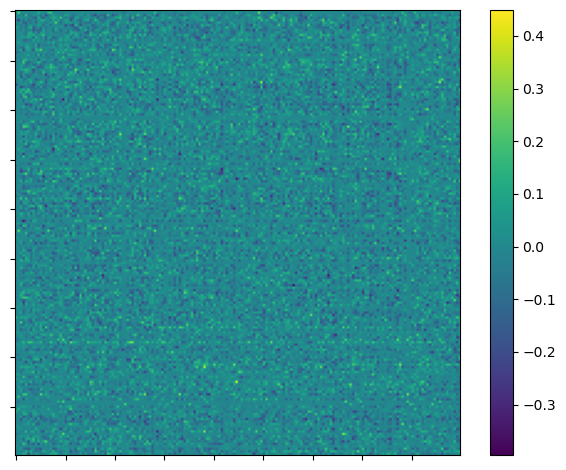

In [133]:
plt.imshow(full_weight_matrix)
plt.yticks(np.arange(0,180,20),[])
plt.xticks(np.arange(0,180,20),[])
plt.tight_layout()
plt.colorbar()
# plt.savefig('eps_images-new/'+'W_recurrent_weights_20%model.pdf',format='pdf')

plt.show()

In [72]:
np.random.shuffle(full_weight_matrix)

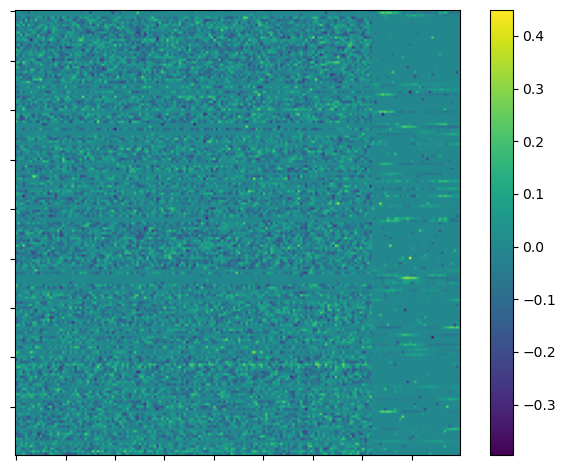

In [74]:
plt.imshow(full_weight_matrix)
plt.yticks(np.arange(0,180,20),[])
plt.xticks(np.arange(0,180,20),[])
plt.tight_layout()
plt.colorbar()
# plt.savefig('eps_images-new/'+'W_recurrent_weights_20%model.pdf',format='pdf')

plt.show()

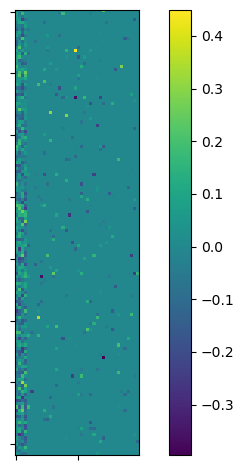

In [52]:
plt.imshow(ww['W_in1_2'])
plt.yticks(np.arange(0,180-bump_population,20),[])
plt.xticks(np.arange(0,bump_population,20),[])
plt.tight_layout()
plt.colorbar()
plt.savefig('eps_images-new/'+'W_input_non-bump_weights_20%model.pdf',format='pdf')
plt.show()

In [44]:
ww['W_in1_1'].shape

(36, 148)

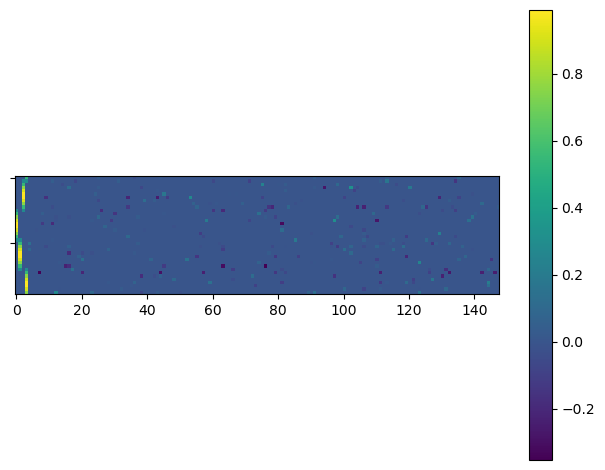

In [53]:
plt.imshow(ww['W_in1_1'])
plt.yticks(np.arange(0,bump_population,20),[])
plt.xticks(np.arange(0,148,20))
plt.tight_layout()
plt.colorbar()
plt.savefig('eps_images-new/'+'W_input_bump_weights_20%model.pdf',format='pdf')
plt.show()

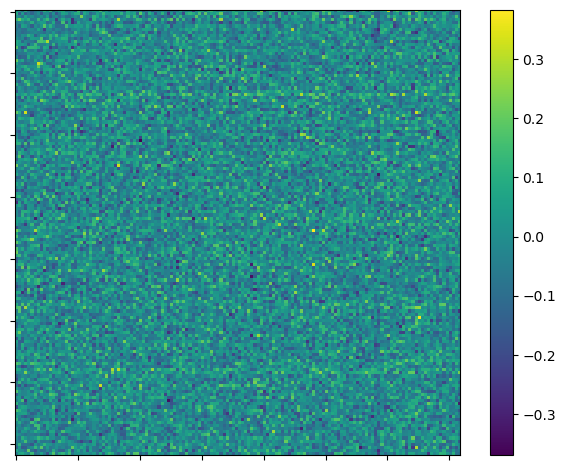

In [54]:
plt.imshow(ww['W_rec1_2'])
plt.yticks(np.arange(0,180-bump_population,20),[])
plt.xticks(np.arange(0,180-bump_population,20),[])
plt.tight_layout()
plt.colorbar()
plt.savefig('eps_images-new/'+'W_recurrent_non-bump_weights_20%model.pdf',format='pdf')

plt.show()

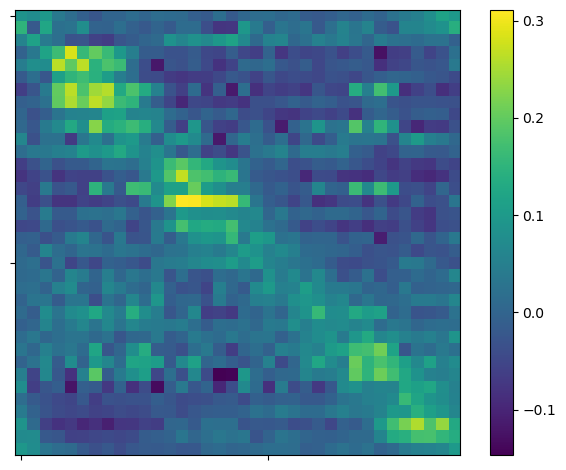

In [55]:
plt.imshow(ww['W_rec1_1'])
plt.yticks(np.arange(0,bump_population,20),[])
plt.xticks(np.arange(0,bump_population,20),[])
plt.tight_layout()
plt.colorbar()
plt.savefig('eps_images-new/'+'W_recurrent_bump_weights_20%model.pdf',format='pdf')

plt.show()

# Load Datasets

In [37]:
# In case there are already extracted model datasets 
dataset = {}
dataset_labels = {}

dataset_output ={}
dataset_gt={}
dataset_mask={}


In [51]:
model_accuracies_fef = defaultdict(list)

for data_folder in data_folder_list:
    print(data_folder)
    for epoch in ['']:
        for bump_percen in bump_percen_range:
            if bump_percen == 0:
                N_rec1 = bump_population
            elif bump_percen == 1:
                N_rec1 = bump_population
            else:
                N_rec1 = int(bump_population/bump_percen) # Number of neurons for region1 
                non_bump_population1 = N_rec1-bump_population # number of non-bump neurons in region1
            for tau in tau_range:
                dt = int(tau*dt_percentage[tau])
                for input_sigma in input_sigma_range:
                    for recurrent_noise in recurrent_noise_range: 
                        for inter_connect_percen in inter_connect_percen_range:
                            for inner_connect_percen in inner_connect_percen_range:
                                params_values = '/stimulus'+str(outputs)+'/dt'+str(dt)+'/tau'+str(tau)+'/input-noise'+str(input_sigma)+'/rec-noise'+str(recurrent_noise)+'/inter-connect'+str(inter_connect_percen)+'/inner-connect'+str(inner_connect_percen)+'/'
                                print(params_values)
                                for model_version in model_version_range:
                                    for region in ['FEF']:
                                        print(region)
                                        for session in np.arange(len(monkey_session_data[region])):
                                            drt = TargetDistractor(N_inputs = inputs, N_outputs=outputs, dt= dt, tau=tau, T=dt*58,
                                                                    cue_start=dt*2, cue_end=dt*8, dis_start=dt*28, dis_end=dt*34, decision_start=dt*54,
                                                                    N_batch = N_batch,
                                                                    sigma=input_sigma)
                                            # name of the model
                                            name1 = name = 'bump'+str(bump_percen)+"_"+str(N_rec1)+'Nrec_' #  Unique name used to determine variable scope for internal use.        
                                            # add the session number in the model name
                                            name = name1+str(model_version)
                                            print("\nIteration: ", model_version, "\nModel name: ", name)

                                            key_name = params_values+name
                                            print(key_name)

                                            dataset[data_folder+key_name+'_'+region+str(session)+'_epoch'+str(epoch)] = np.load(data_folder+key_name+'_'+region+str(session)+'_trial_data_epoch'+str(epoch)+'.npy')
                                            dataset_labels[data_folder+key_name+'_'+region+str(session)+'_epoch'+str(epoch)] = np.load(data_folder+key_name+'_'+region+str(session)+'_trial_labels_epoch'+str(epoch)+'.npy')
                                            dataset_output[data_folder+key_name+'_'+region+str(session)+'_epoch'+str(epoch)] = np.load(data_folder+key_name+'_'+region+str(session)+'_mixed-model_output_epoch'+str(epoch)+'.npy')
                                            dataset_gt[data_folder+key_name+'_'+region+str(session)+'_epoch'+str(epoch)] = np.load(data_folder+key_name+'_'+region+str(session)+'_mixed-model_gt_epoch'+str(epoch)+'.npy')
                                            dataset_mask[data_folder+key_name+'_'+region+str(session)+'_epoch'+str(epoch)] = np.load(data_folder+key_name+'_'+region+str(session)+'_mixed-model_mask_epoch'+str(epoch)+'.npy')

#                                             if region == 'FEF':
#                                                 model_accuracies_fef[data_folder+params_values+name1+'_'+region+'_accuracies'].append(drt.accuracy_function(dataset_gt[data_folder+key_name+'_'+region+str(session)+'_epoch'+str(epoch)],
#                                                                                                                                          dataset_output[data_folder+key_name+'_'+region+str(session)+'_epoch'+str(epoch)],
#                                                                                                                                          dataset_mask[data_folder+key_name+'_'+region+str(session)+'_epoch'+str(epoch)]))


exploring-inner-connection-of-datasets
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/
FEF

Iteration:  0 
Model name:  bump0.05_720Nrec_0
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.05_720Nrec_0

Iteration:  0 
Model name:  bump0.05_720Nrec_0
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.05_720Nrec_0

Iteration:  0 
Model name:  bump0.05_720Nrec_0
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.05_720Nrec_0

Iteration:  0 
Model name:  bump0.05_720Nrec_0
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.05_720Nrec_0

Iteration:  0 
Model name:  bump0.05_720Nrec_0
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.05_720Nrec_0

Iteration:  0 
Model name:  bump0.05_720Nrec_0
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inte


Iteration:  2 
Model name:  bump0.05_720Nrec_2
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.05_720Nrec_2

Iteration:  2 
Model name:  bump0.05_720Nrec_2
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.05_720Nrec_2

Iteration:  2 
Model name:  bump0.05_720Nrec_2
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.05_720Nrec_2

Iteration:  2 
Model name:  bump0.05_720Nrec_2
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.05_720Nrec_2

Iteration:  2 
Model name:  bump0.05_720Nrec_2
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.05_720Nrec_2

Iteration:  2 
Model name:  bump0.05_720Nrec_2
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.05_720Nrec_2

Iteration:  2 
Model name:  bump0.05_720Nrec_2
/stimulus4/dt50/tau200/input-noise


Iteration:  4 
Model name:  bump0.05_720Nrec_4
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.05_720Nrec_4

Iteration:  4 
Model name:  bump0.05_720Nrec_4
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.05_720Nrec_4

Iteration:  4 
Model name:  bump0.05_720Nrec_4
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.05_720Nrec_4

Iteration:  4 
Model name:  bump0.05_720Nrec_4
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.05_720Nrec_4

Iteration:  4 
Model name:  bump0.05_720Nrec_4
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.05_720Nrec_4

Iteration:  4 
Model name:  bump0.05_720Nrec_4
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.05_720Nrec_4

Iteration:  4 
Model name:  bump0.05_720Nrec_4
/stimulus4/dt50/tau200/input-noise


Iteration:  6 
Model name:  bump0.05_720Nrec_6
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.05_720Nrec_6

Iteration:  6 
Model name:  bump0.05_720Nrec_6
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.05_720Nrec_6

Iteration:  6 
Model name:  bump0.05_720Nrec_6
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.05_720Nrec_6

Iteration:  6 
Model name:  bump0.05_720Nrec_6
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.05_720Nrec_6

Iteration:  6 
Model name:  bump0.05_720Nrec_6
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.05_720Nrec_6

Iteration:  6 
Model name:  bump0.05_720Nrec_6
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.05_720Nrec_6

Iteration:  6 
Model name:  bump0.05_720Nrec_6
/stimulus4/dt50/tau200/input-noise


Iteration:  8 
Model name:  bump0.05_720Nrec_8
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.05_720Nrec_8

Iteration:  8 
Model name:  bump0.05_720Nrec_8
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.05_720Nrec_8

Iteration:  8 
Model name:  bump0.05_720Nrec_8
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.05_720Nrec_8

Iteration:  8 
Model name:  bump0.05_720Nrec_8
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.05_720Nrec_8

Iteration:  8 
Model name:  bump0.05_720Nrec_8
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.05_720Nrec_8

Iteration:  8 
Model name:  bump0.05_720Nrec_8
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.05_720Nrec_8

Iteration:  8 
Model name:  bump0.05_720Nrec_8
/stimulus4/dt50/tau200/input-noise


Iteration:  0 
Model name:  bump0.1_360Nrec_0
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.1_360Nrec_0

Iteration:  0 
Model name:  bump0.1_360Nrec_0
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.1_360Nrec_0

Iteration:  0 
Model name:  bump0.1_360Nrec_0
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.1_360Nrec_0

Iteration:  0 
Model name:  bump0.1_360Nrec_0
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.1_360Nrec_0

Iteration:  0 
Model name:  bump0.1_360Nrec_0
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.1_360Nrec_0

Iteration:  0 
Model name:  bump0.1_360Nrec_0
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.1_360Nrec_0

Iteration:  0 
Model name:  bump0.1_360Nrec_0
/stimulus4/dt50/tau200/input-noise0.01/rec-nois


Iteration:  2 
Model name:  bump0.1_360Nrec_2
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.1_360Nrec_2

Iteration:  2 
Model name:  bump0.1_360Nrec_2
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.1_360Nrec_2

Iteration:  2 
Model name:  bump0.1_360Nrec_2
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.1_360Nrec_2

Iteration:  2 
Model name:  bump0.1_360Nrec_2
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.1_360Nrec_2

Iteration:  2 
Model name:  bump0.1_360Nrec_2
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.1_360Nrec_2

Iteration:  2 
Model name:  bump0.1_360Nrec_2
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.1_360Nrec_2

Iteration:  2 
Model name:  bump0.1_360Nrec_2
/stimulus4/dt50/tau200/input-noise0.01/rec-nois


Iteration:  4 
Model name:  bump0.1_360Nrec_4
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.1_360Nrec_4

Iteration:  4 
Model name:  bump0.1_360Nrec_4
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.1_360Nrec_4

Iteration:  4 
Model name:  bump0.1_360Nrec_4
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.1_360Nrec_4

Iteration:  4 
Model name:  bump0.1_360Nrec_4
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.1_360Nrec_4

Iteration:  4 
Model name:  bump0.1_360Nrec_4
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.1_360Nrec_4

Iteration:  4 
Model name:  bump0.1_360Nrec_4
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.1_360Nrec_4

Iteration:  4 
Model name:  bump0.1_360Nrec_4
/stimulus4/dt50/tau200/input-noise0.01/rec-nois


Iteration:  6 
Model name:  bump0.1_360Nrec_6
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.1_360Nrec_6

Iteration:  6 
Model name:  bump0.1_360Nrec_6
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.1_360Nrec_6

Iteration:  6 
Model name:  bump0.1_360Nrec_6
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.1_360Nrec_6

Iteration:  6 
Model name:  bump0.1_360Nrec_6
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.1_360Nrec_6

Iteration:  6 
Model name:  bump0.1_360Nrec_6
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.1_360Nrec_6

Iteration:  6 
Model name:  bump0.1_360Nrec_6
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.1_360Nrec_6

Iteration:  6 
Model name:  bump0.1_360Nrec_6
/stimulus4/dt50/tau200/input-noise0.01/rec-nois


Iteration:  8 
Model name:  bump0.1_360Nrec_8
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.1_360Nrec_8

Iteration:  8 
Model name:  bump0.1_360Nrec_8
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.1_360Nrec_8

Iteration:  8 
Model name:  bump0.1_360Nrec_8
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.1_360Nrec_8

Iteration:  8 
Model name:  bump0.1_360Nrec_8
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.1_360Nrec_8

Iteration:  8 
Model name:  bump0.1_360Nrec_8
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.1_360Nrec_8
FEF

Iteration:  9 
Model name:  bump0.1_360Nrec_9
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.1_360Nrec_9

Iteration:  9 
Model name:  bump0.1_360Nrec_9
/stimulus4/dt50/tau200/input-noise0.01/rec-


Iteration:  0 
Model name:  bump0.3_120Nrec_0
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.3_120Nrec_0

Iteration:  0 
Model name:  bump0.3_120Nrec_0
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.3_120Nrec_0

Iteration:  0 
Model name:  bump0.3_120Nrec_0
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.3_120Nrec_0
FEF

Iteration:  1 
Model name:  bump0.3_120Nrec_1
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.3_120Nrec_1

Iteration:  1 
Model name:  bump0.3_120Nrec_1
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.3_120Nrec_1

Iteration:  1 
Model name:  bump0.3_120Nrec_1
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.3_120Nrec_1

Iteration:  1 
Model name:  bump0.3_120Nrec_1
/stimulus4/dt50/tau200/input-noise0.01/rec-


Iteration:  3 
Model name:  bump0.3_120Nrec_3
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.3_120Nrec_3

Iteration:  3 
Model name:  bump0.3_120Nrec_3
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.3_120Nrec_3

Iteration:  3 
Model name:  bump0.3_120Nrec_3
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.3_120Nrec_3

Iteration:  3 
Model name:  bump0.3_120Nrec_3
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.3_120Nrec_3

Iteration:  3 
Model name:  bump0.3_120Nrec_3
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.3_120Nrec_3

Iteration:  3 
Model name:  bump0.3_120Nrec_3
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.3_120Nrec_3

Iteration:  3 
Model name:  bump0.3_120Nrec_3
/stimulus4/dt50/tau200/input-noise0.01/rec-nois


Iteration:  5 
Model name:  bump0.3_120Nrec_5
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.3_120Nrec_5

Iteration:  5 
Model name:  bump0.3_120Nrec_5
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.3_120Nrec_5

Iteration:  5 
Model name:  bump0.3_120Nrec_5
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.3_120Nrec_5

Iteration:  5 
Model name:  bump0.3_120Nrec_5
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.3_120Nrec_5

Iteration:  5 
Model name:  bump0.3_120Nrec_5
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.3_120Nrec_5

Iteration:  5 
Model name:  bump0.3_120Nrec_5
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.3_120Nrec_5

Iteration:  5 
Model name:  bump0.3_120Nrec_5
/stimulus4/dt50/tau200/input-noise0.01/rec-nois


Iteration:  7 
Model name:  bump0.3_120Nrec_7
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.3_120Nrec_7

Iteration:  7 
Model name:  bump0.3_120Nrec_7
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.3_120Nrec_7

Iteration:  7 
Model name:  bump0.3_120Nrec_7
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.3_120Nrec_7

Iteration:  7 
Model name:  bump0.3_120Nrec_7
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.3_120Nrec_7

Iteration:  7 
Model name:  bump0.3_120Nrec_7
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.3_120Nrec_7

Iteration:  7 
Model name:  bump0.3_120Nrec_7
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.3_120Nrec_7

Iteration:  7 
Model name:  bump0.3_120Nrec_7
/stimulus4/dt50/tau200/input-noise0.01/rec-nois


Iteration:  9 
Model name:  bump0.3_120Nrec_9
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.3_120Nrec_9

Iteration:  9 
Model name:  bump0.3_120Nrec_9
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.3_120Nrec_9

Iteration:  9 
Model name:  bump0.3_120Nrec_9
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.3_120Nrec_9

Iteration:  9 
Model name:  bump0.3_120Nrec_9
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.3_120Nrec_9

Iteration:  9 
Model name:  bump0.3_120Nrec_9
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.3_120Nrec_9

Iteration:  9 
Model name:  bump0.3_120Nrec_9
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.3_120Nrec_9

Iteration:  9 
Model name:  bump0.3_120Nrec_9
/stimulus4/dt50/tau200/input-noise0.01/rec-nois


Iteration:  1 
Model name:  bump0.4_90Nrec_1
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.4_90Nrec_1

Iteration:  1 
Model name:  bump0.4_90Nrec_1
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.4_90Nrec_1

Iteration:  1 
Model name:  bump0.4_90Nrec_1
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.4_90Nrec_1

Iteration:  1 
Model name:  bump0.4_90Nrec_1
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.4_90Nrec_1

Iteration:  1 
Model name:  bump0.4_90Nrec_1
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.4_90Nrec_1

Iteration:  1 
Model name:  bump0.4_90Nrec_1
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.4_90Nrec_1

Iteration:  1 
Model name:  bump0.4_90Nrec_1
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-c


Iteration:  3 
Model name:  bump0.4_90Nrec_3
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.4_90Nrec_3

Iteration:  3 
Model name:  bump0.4_90Nrec_3
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.4_90Nrec_3

Iteration:  3 
Model name:  bump0.4_90Nrec_3
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.4_90Nrec_3

Iteration:  3 
Model name:  bump0.4_90Nrec_3
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.4_90Nrec_3

Iteration:  3 
Model name:  bump0.4_90Nrec_3
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.4_90Nrec_3

Iteration:  3 
Model name:  bump0.4_90Nrec_3
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.4_90Nrec_3

Iteration:  3 
Model name:  bump0.4_90Nrec_3
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-c


Iteration:  5 
Model name:  bump0.4_90Nrec_5
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.4_90Nrec_5

Iteration:  5 
Model name:  bump0.4_90Nrec_5
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.4_90Nrec_5

Iteration:  5 
Model name:  bump0.4_90Nrec_5
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.4_90Nrec_5

Iteration:  5 
Model name:  bump0.4_90Nrec_5
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.4_90Nrec_5

Iteration:  5 
Model name:  bump0.4_90Nrec_5
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.4_90Nrec_5

Iteration:  5 
Model name:  bump0.4_90Nrec_5
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.4_90Nrec_5

Iteration:  5 
Model name:  bump0.4_90Nrec_5
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-c


Iteration:  7 
Model name:  bump0.4_90Nrec_7
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.4_90Nrec_7

Iteration:  7 
Model name:  bump0.4_90Nrec_7
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.4_90Nrec_7

Iteration:  7 
Model name:  bump0.4_90Nrec_7
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.4_90Nrec_7

Iteration:  7 
Model name:  bump0.4_90Nrec_7
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.4_90Nrec_7
FEF

Iteration:  8 
Model name:  bump0.4_90Nrec_8
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.4_90Nrec_8

Iteration:  8 
Model name:  bump0.4_90Nrec_8
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.4_90Nrec_8

Iteration:  8 
Model name:  bump0.4_90Nrec_8
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/int


Iteration:  9 
Model name:  bump0.4_90Nrec_9
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.4_90Nrec_9
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/
FEF

Iteration:  0 
Model name:  bump0.5_72Nrec_0
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.5_72Nrec_0

Iteration:  0 
Model name:  bump0.5_72Nrec_0
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.5_72Nrec_0

Iteration:  0 
Model name:  bump0.5_72Nrec_0
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.5_72Nrec_0

Iteration:  0 
Model name:  bump0.5_72Nrec_0
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.5_72Nrec_0

Iteration:  0 
Model name:  bump0.5_72Nrec_0
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.5_72Nrec_0

Iteration:  0 


Iteration:  2 
Model name:  bump0.5_72Nrec_2
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.5_72Nrec_2

Iteration:  2 
Model name:  bump0.5_72Nrec_2
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.5_72Nrec_2

Iteration:  2 
Model name:  bump0.5_72Nrec_2
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.5_72Nrec_2

Iteration:  2 
Model name:  bump0.5_72Nrec_2
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.5_72Nrec_2

Iteration:  2 
Model name:  bump0.5_72Nrec_2
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.5_72Nrec_2

Iteration:  2 
Model name:  bump0.5_72Nrec_2
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.5_72Nrec_2

Iteration:  2 
Model name:  bump0.5_72Nrec_2
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-c


Iteration:  4 
Model name:  bump0.5_72Nrec_4
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.5_72Nrec_4

Iteration:  4 
Model name:  bump0.5_72Nrec_4
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.5_72Nrec_4

Iteration:  4 
Model name:  bump0.5_72Nrec_4
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.5_72Nrec_4

Iteration:  4 
Model name:  bump0.5_72Nrec_4
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.5_72Nrec_4

Iteration:  4 
Model name:  bump0.5_72Nrec_4
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.5_72Nrec_4

Iteration:  4 
Model name:  bump0.5_72Nrec_4
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.5_72Nrec_4

Iteration:  4 
Model name:  bump0.5_72Nrec_4
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-c


Iteration:  6 
Model name:  bump0.5_72Nrec_6
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.5_72Nrec_6

Iteration:  6 
Model name:  bump0.5_72Nrec_6
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.5_72Nrec_6

Iteration:  6 
Model name:  bump0.5_72Nrec_6
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.5_72Nrec_6

Iteration:  6 
Model name:  bump0.5_72Nrec_6
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.5_72Nrec_6

Iteration:  6 
Model name:  bump0.5_72Nrec_6
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.5_72Nrec_6

Iteration:  6 
Model name:  bump0.5_72Nrec_6
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.5_72Nrec_6

Iteration:  6 
Model name:  bump0.5_72Nrec_6
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-c


Iteration:  8 
Model name:  bump0.5_72Nrec_8
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.5_72Nrec_8

Iteration:  8 
Model name:  bump0.5_72Nrec_8
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.5_72Nrec_8

Iteration:  8 
Model name:  bump0.5_72Nrec_8
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.5_72Nrec_8

Iteration:  8 
Model name:  bump0.5_72Nrec_8
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.5_72Nrec_8

Iteration:  8 
Model name:  bump0.5_72Nrec_8
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.5_72Nrec_8

Iteration:  8 
Model name:  bump0.5_72Nrec_8
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.5_72Nrec_8

Iteration:  8 
Model name:  bump0.5_72Nrec_8
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-c


Iteration:  0 
Model name:  bump0.6_60Nrec_0
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.6_60Nrec_0

Iteration:  0 
Model name:  bump0.6_60Nrec_0
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.6_60Nrec_0

Iteration:  0 
Model name:  bump0.6_60Nrec_0
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.6_60Nrec_0

Iteration:  0 
Model name:  bump0.6_60Nrec_0
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.6_60Nrec_0

Iteration:  0 
Model name:  bump0.6_60Nrec_0
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.6_60Nrec_0

Iteration:  0 
Model name:  bump0.6_60Nrec_0
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.6_60Nrec_0

Iteration:  0 
Model name:  bump0.6_60Nrec_0
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-c


Iteration:  2 
Model name:  bump0.6_60Nrec_2
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.6_60Nrec_2

Iteration:  2 
Model name:  bump0.6_60Nrec_2
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.6_60Nrec_2

Iteration:  2 
Model name:  bump0.6_60Nrec_2
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.6_60Nrec_2

Iteration:  2 
Model name:  bump0.6_60Nrec_2
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.6_60Nrec_2

Iteration:  2 
Model name:  bump0.6_60Nrec_2
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.6_60Nrec_2

Iteration:  2 
Model name:  bump0.6_60Nrec_2
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.6_60Nrec_2
FEF

Iteration:  3 
Model name:  bump0.6_60Nrec_3
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/int


Iteration:  4 
Model name:  bump0.6_60Nrec_4
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.6_60Nrec_4

Iteration:  4 
Model name:  bump0.6_60Nrec_4
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.6_60Nrec_4

Iteration:  4 
Model name:  bump0.6_60Nrec_4
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.6_60Nrec_4
FEF

Iteration:  5 
Model name:  bump0.6_60Nrec_5
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.6_60Nrec_5

Iteration:  5 
Model name:  bump0.6_60Nrec_5
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.6_60Nrec_5

Iteration:  5 
Model name:  bump0.6_60Nrec_5
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.6_60Nrec_5

Iteration:  5 
Model name:  bump0.6_60Nrec_5
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/int

FEF

Iteration:  7 
Model name:  bump0.6_60Nrec_7
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.6_60Nrec_7

Iteration:  7 
Model name:  bump0.6_60Nrec_7
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.6_60Nrec_7

Iteration:  7 
Model name:  bump0.6_60Nrec_7
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.6_60Nrec_7

Iteration:  7 
Model name:  bump0.6_60Nrec_7
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.6_60Nrec_7

Iteration:  7 
Model name:  bump0.6_60Nrec_7
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.6_60Nrec_7

Iteration:  7 
Model name:  bump0.6_60Nrec_7
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.6_60Nrec_7

Iteration:  7 
Model name:  bump0.6_60Nrec_7
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/int


Iteration:  9 
Model name:  bump0.6_60Nrec_9
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.6_60Nrec_9

Iteration:  9 
Model name:  bump0.6_60Nrec_9
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.6_60Nrec_9

Iteration:  9 
Model name:  bump0.6_60Nrec_9
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.6_60Nrec_9

Iteration:  9 
Model name:  bump0.6_60Nrec_9
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.6_60Nrec_9

Iteration:  9 
Model name:  bump0.6_60Nrec_9
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.6_60Nrec_9

Iteration:  9 
Model name:  bump0.6_60Nrec_9
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.6_60Nrec_9

Iteration:  9 
Model name:  bump0.6_60Nrec_9
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-c


Iteration:  1 
Model name:  bump0.7_51Nrec_1
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.7_51Nrec_1

Iteration:  1 
Model name:  bump0.7_51Nrec_1
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.7_51Nrec_1

Iteration:  1 
Model name:  bump0.7_51Nrec_1
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.7_51Nrec_1

Iteration:  1 
Model name:  bump0.7_51Nrec_1
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.7_51Nrec_1

Iteration:  1 
Model name:  bump0.7_51Nrec_1
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.7_51Nrec_1

Iteration:  1 
Model name:  bump0.7_51Nrec_1
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.7_51Nrec_1

Iteration:  1 
Model name:  bump0.7_51Nrec_1
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-c


Iteration:  3 
Model name:  bump0.7_51Nrec_3
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.7_51Nrec_3

Iteration:  3 
Model name:  bump0.7_51Nrec_3
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.7_51Nrec_3

Iteration:  3 
Model name:  bump0.7_51Nrec_3
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.7_51Nrec_3

Iteration:  3 
Model name:  bump0.7_51Nrec_3
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.7_51Nrec_3

Iteration:  3 
Model name:  bump0.7_51Nrec_3
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.7_51Nrec_3

Iteration:  3 
Model name:  bump0.7_51Nrec_3
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.7_51Nrec_3

Iteration:  3 
Model name:  bump0.7_51Nrec_3
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-c


Iteration:  5 
Model name:  bump0.7_51Nrec_5
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.7_51Nrec_5

Iteration:  5 
Model name:  bump0.7_51Nrec_5
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.7_51Nrec_5

Iteration:  5 
Model name:  bump0.7_51Nrec_5
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.7_51Nrec_5

Iteration:  5 
Model name:  bump0.7_51Nrec_5
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.7_51Nrec_5

Iteration:  5 
Model name:  bump0.7_51Nrec_5
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.7_51Nrec_5

Iteration:  5 
Model name:  bump0.7_51Nrec_5
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.7_51Nrec_5

Iteration:  5 
Model name:  bump0.7_51Nrec_5
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-c


Iteration:  7 
Model name:  bump0.7_51Nrec_7
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.7_51Nrec_7

Iteration:  7 
Model name:  bump0.7_51Nrec_7
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.7_51Nrec_7

Iteration:  7 
Model name:  bump0.7_51Nrec_7
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.7_51Nrec_7

Iteration:  7 
Model name:  bump0.7_51Nrec_7
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.7_51Nrec_7

Iteration:  7 
Model name:  bump0.7_51Nrec_7
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.7_51Nrec_7

Iteration:  7 
Model name:  bump0.7_51Nrec_7
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.7_51Nrec_7

Iteration:  7 
Model name:  bump0.7_51Nrec_7
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-c


Iteration:  9 
Model name:  bump0.7_51Nrec_9
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.7_51Nrec_9

Iteration:  9 
Model name:  bump0.7_51Nrec_9
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.7_51Nrec_9

Iteration:  9 
Model name:  bump0.7_51Nrec_9
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.7_51Nrec_9

Iteration:  9 
Model name:  bump0.7_51Nrec_9
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.7_51Nrec_9

Iteration:  9 
Model name:  bump0.7_51Nrec_9
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.7_51Nrec_9

Iteration:  9 
Model name:  bump0.7_51Nrec_9
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.7_51Nrec_9
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/
FEF

Iteration:  0 


Iteration:  1 
Model name:  bump0.8_45Nrec_1
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.8_45Nrec_1

Iteration:  1 
Model name:  bump0.8_45Nrec_1
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.8_45Nrec_1
FEF

Iteration:  2 
Model name:  bump0.8_45Nrec_2
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.8_45Nrec_2

Iteration:  2 
Model name:  bump0.8_45Nrec_2
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.8_45Nrec_2

Iteration:  2 
Model name:  bump0.8_45Nrec_2
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.8_45Nrec_2

Iteration:  2 
Model name:  bump0.8_45Nrec_2
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.8_45Nrec_2

Iteration:  2 
Model name:  bump0.8_45Nrec_2
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/int


Iteration:  4 
Model name:  bump0.8_45Nrec_4
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.8_45Nrec_4

Iteration:  4 
Model name:  bump0.8_45Nrec_4
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.8_45Nrec_4

Iteration:  4 
Model name:  bump0.8_45Nrec_4
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.8_45Nrec_4

Iteration:  4 
Model name:  bump0.8_45Nrec_4
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.8_45Nrec_4

Iteration:  4 
Model name:  bump0.8_45Nrec_4
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.8_45Nrec_4

Iteration:  4 
Model name:  bump0.8_45Nrec_4
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.8_45Nrec_4

Iteration:  4 
Model name:  bump0.8_45Nrec_4
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-c


Iteration:  6 
Model name:  bump0.8_45Nrec_6
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.8_45Nrec_6

Iteration:  6 
Model name:  bump0.8_45Nrec_6
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.8_45Nrec_6

Iteration:  6 
Model name:  bump0.8_45Nrec_6
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.8_45Nrec_6

Iteration:  6 
Model name:  bump0.8_45Nrec_6
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.8_45Nrec_6

Iteration:  6 
Model name:  bump0.8_45Nrec_6
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.8_45Nrec_6

Iteration:  6 
Model name:  bump0.8_45Nrec_6
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.8_45Nrec_6

Iteration:  6 
Model name:  bump0.8_45Nrec_6
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-c


Iteration:  8 
Model name:  bump0.8_45Nrec_8
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.8_45Nrec_8

Iteration:  8 
Model name:  bump0.8_45Nrec_8
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.8_45Nrec_8

Iteration:  8 
Model name:  bump0.8_45Nrec_8
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.8_45Nrec_8

Iteration:  8 
Model name:  bump0.8_45Nrec_8
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.8_45Nrec_8

Iteration:  8 
Model name:  bump0.8_45Nrec_8
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.8_45Nrec_8

Iteration:  8 
Model name:  bump0.8_45Nrec_8
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.8_45Nrec_8

Iteration:  8 
Model name:  bump0.8_45Nrec_8
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-c


Iteration:  0 
Model name:  bump0.9_40Nrec_0
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.9_40Nrec_0

Iteration:  0 
Model name:  bump0.9_40Nrec_0
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.9_40Nrec_0

Iteration:  0 
Model name:  bump0.9_40Nrec_0
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.9_40Nrec_0

Iteration:  0 
Model name:  bump0.9_40Nrec_0
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.9_40Nrec_0

Iteration:  0 
Model name:  bump0.9_40Nrec_0
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.9_40Nrec_0

Iteration:  0 
Model name:  bump0.9_40Nrec_0
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.9_40Nrec_0

Iteration:  0 
Model name:  bump0.9_40Nrec_0
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-c


Iteration:  2 
Model name:  bump0.9_40Nrec_2
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.9_40Nrec_2

Iteration:  2 
Model name:  bump0.9_40Nrec_2
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.9_40Nrec_2

Iteration:  2 
Model name:  bump0.9_40Nrec_2
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.9_40Nrec_2

Iteration:  2 
Model name:  bump0.9_40Nrec_2
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.9_40Nrec_2

Iteration:  2 
Model name:  bump0.9_40Nrec_2
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.9_40Nrec_2

Iteration:  2 
Model name:  bump0.9_40Nrec_2
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.9_40Nrec_2

Iteration:  2 
Model name:  bump0.9_40Nrec_2
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-c


Iteration:  4 
Model name:  bump0.9_40Nrec_4
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.9_40Nrec_4

Iteration:  4 
Model name:  bump0.9_40Nrec_4
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.9_40Nrec_4

Iteration:  4 
Model name:  bump0.9_40Nrec_4
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.9_40Nrec_4

Iteration:  4 
Model name:  bump0.9_40Nrec_4
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.9_40Nrec_4

Iteration:  4 
Model name:  bump0.9_40Nrec_4
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.9_40Nrec_4

Iteration:  4 
Model name:  bump0.9_40Nrec_4
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.9_40Nrec_4

Iteration:  4 
Model name:  bump0.9_40Nrec_4
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-c


Iteration:  6 
Model name:  bump0.9_40Nrec_6
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.9_40Nrec_6

Iteration:  6 
Model name:  bump0.9_40Nrec_6
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.9_40Nrec_6

Iteration:  6 
Model name:  bump0.9_40Nrec_6
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.9_40Nrec_6
FEF

Iteration:  7 
Model name:  bump0.9_40Nrec_7
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.9_40Nrec_7

Iteration:  7 
Model name:  bump0.9_40Nrec_7
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.9_40Nrec_7

Iteration:  7 
Model name:  bump0.9_40Nrec_7
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.9_40Nrec_7

Iteration:  7 
Model name:  bump0.9_40Nrec_7
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/int


Iteration:  9 
Model name:  bump0.9_40Nrec_9
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.9_40Nrec_9

Iteration:  9 
Model name:  bump0.9_40Nrec_9
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.9_40Nrec_9

Iteration:  9 
Model name:  bump0.9_40Nrec_9
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.9_40Nrec_9

Iteration:  9 
Model name:  bump0.9_40Nrec_9
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.9_40Nrec_9

Iteration:  9 
Model name:  bump0.9_40Nrec_9
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.9_40Nrec_9

Iteration:  9 
Model name:  bump0.9_40Nrec_9
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump0.9_40Nrec_9

Iteration:  9 
Model name:  bump0.9_40Nrec_9
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-c


Iteration:  1 
Model name:  bump1_36Nrec_1
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump1_36Nrec_1

Iteration:  1 
Model name:  bump1_36Nrec_1
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump1_36Nrec_1

Iteration:  1 
Model name:  bump1_36Nrec_1
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump1_36Nrec_1

Iteration:  1 
Model name:  bump1_36Nrec_1
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump1_36Nrec_1

Iteration:  1 
Model name:  bump1_36Nrec_1
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump1_36Nrec_1

Iteration:  1 
Model name:  bump1_36Nrec_1
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump1_36Nrec_1

Iteration:  1 
Model name:  bump1_36Nrec_1
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/


Iteration:  3 
Model name:  bump1_36Nrec_3
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump1_36Nrec_3

Iteration:  3 
Model name:  bump1_36Nrec_3
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump1_36Nrec_3

Iteration:  3 
Model name:  bump1_36Nrec_3
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump1_36Nrec_3

Iteration:  3 
Model name:  bump1_36Nrec_3
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump1_36Nrec_3

Iteration:  3 
Model name:  bump1_36Nrec_3
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump1_36Nrec_3

Iteration:  3 
Model name:  bump1_36Nrec_3
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump1_36Nrec_3

Iteration:  3 
Model name:  bump1_36Nrec_3
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/


Iteration:  5 
Model name:  bump1_36Nrec_5
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump1_36Nrec_5

Iteration:  5 
Model name:  bump1_36Nrec_5
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump1_36Nrec_5

Iteration:  5 
Model name:  bump1_36Nrec_5
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump1_36Nrec_5

Iteration:  5 
Model name:  bump1_36Nrec_5
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump1_36Nrec_5

Iteration:  5 
Model name:  bump1_36Nrec_5
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump1_36Nrec_5

Iteration:  5 
Model name:  bump1_36Nrec_5
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump1_36Nrec_5

Iteration:  5 
Model name:  bump1_36Nrec_5
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/


Iteration:  7 
Model name:  bump1_36Nrec_7
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump1_36Nrec_7

Iteration:  7 
Model name:  bump1_36Nrec_7
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump1_36Nrec_7

Iteration:  7 
Model name:  bump1_36Nrec_7
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump1_36Nrec_7
FEF

Iteration:  8 
Model name:  bump1_36Nrec_8
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump1_36Nrec_8

Iteration:  8 
Model name:  bump1_36Nrec_8
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump1_36Nrec_8

Iteration:  8 
Model name:  bump1_36Nrec_8
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0.05/bump1_36Nrec_8

Iteration:  8 
Model name:  bump1_36Nrec_8
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.09/inter-connect0/inner-connect0

# Correlation analysis

In [17]:
# Set parameters for the Correlation analysis
hist_bins = 50
histogram_xrange = [-1, 1]

model_percentages = defaultdict(list)

np.random.seed(10)

all_neurons = defaultdict(list)
all_neurons_labels = defaultdict(list)

significance_level_range = [1e-5]
p_value_threshold = [1e-5]

method = 't-test-locations'

version_pairs_region1 = {}
version_correlations_region1 = {}
version_pvalues_region1 = {}

model_plot_pairs_bump_low = defaultdict(list)
model_plot_pairs_nonbump_low = defaultdict(list)
model_plot_pairs_corr_mix_low = defaultdict(list)
model_plot_all_high_p_value_pairs = defaultdict(list)

# Load

In [23]:
# In case there are saved correlation analysis data to load
tau=200
inner_connect_percen=0.05
dt = int(tau*dt_percentage[tau])

In [28]:
with open('saved_results/model_percentages-'+data_folder+str(tau)+'-inner-connect'+str(inner_connect_percen)+'-FEF-FULL.pkl','rb') as f:
    model_percentages = pickle.load(f)

In [29]:
with open('saved_results/'+data_folder+'-inner-connect'+str(inner_connect_percen)+'all_neurons_data-FEF-FULL.pkl', 'rb') as f:
    all_neurons = pickle.load(f)

with open('saved_results/'+data_folder+'-inner-connect'+str(inner_connect_percen)+'all_neurons_labels-FEF-FULL.pkl', 'rb') as f:
    all_neurons_labels = pickle.load(f)

In [41]:
with open('saved_results/'+data_folder+'pair_corr_bump_low-no-motor-tau'+str(tau)+'dt'+str(dt)+'-inner-connect'+str(inner_connect_percen)+'-FEF-FULL.pkl', 'rb') as f:
    model_plot_pairs_bump_low = pickle.load(f)
with open('saved_results/'+data_folder+'pair_corr_nonbump_low-no-motor-tau'+str(tau)+'dt'+str(dt)+'-inner-connect'+str(inner_connect_percen)+'-FEF-FULL.pkl', 'rb') as f:
    model_plot_pairs_nonbump_low = pickle.load(f)
with open('saved_results/'+data_folder+'pair_corr_mix_low-no-motor-tau'+str(tau)+'dt'+str(dt)+'-inner-connect'+str(inner_connect_percen)+'-FEF-FULL.pkl', 'rb') as f:
    model_plot_pairs_corr_mix_low = pickle.load(f)
with open('saved_results/'+data_folder+'all_high_p_value_pairs-no-motor-tau'+str(tau)+'dt'+str(dt)+'-inner-connect'+str(inner_connect_percen)+'-FEF-FULL.pkl', 'rb') as f:
    model_plot_all_high_p_value_pairs = pickle.load(f)

In [30]:
with open('saved_results/model_significant_neuron_percentages-'+data_folder+str(tau)+'-inner-connect'+str(inner_connect_percen)+'-FEF-FULL.pkl','rb') as f:
    model_significant_neuron_percentages = pickle.load(f)
with open('saved_results/model_significant_pair_percentages-'+data_folder+str(tau)+'-inner-connect'+str(inner_connect_percen)+'-FEF-FULL.pkl','rb') as f:
    model_significant_pair_percentages = pickle.load(f)
with open('saved_results/model_total_significant_non_bump_neurons-'+data_folder+str(tau)+'-inner-connect'+str(inner_connect_percen)+'-FEF-FULL.pkl','rb') as f:
    model_total_significant_non_bump_neuron = pickle.load(f)
with open('saved_results/model_total_significant_bump_neurons-'+data_folder+str(tau)+'-inner-connect'+str(inner_connect_percen)+'-FEF-FULL.pkl','rb') as f:
    model_total_significant_bump_neuron = pickle.load(f)
with open('saved_results/model_total_non_significant_non_bump_neurons-'+data_folder+str(tau)+'-inner-connect'+str(inner_connect_percen)+'-FEF-FULL.pkl','rb') as f:
    model_total_non_significant_non_bump_neuron = pickle.load(f)
with open('saved_results/model_total_non_significant_bump_neurons-'+data_folder+str(tau)+'-inner-connect'+str(inner_connect_percen)+'-FEF-FULL.pkl','rb') as f:
    model_total_non_significant_bump_neuron = pickle.load(f)

# Save 

In [56]:
with open('saved_results/'+'model_percentages-'+data_folder+str(tau)+'-inner-connect'+str(inner_connect_percen)+'-FEF-FULL.pkl','wb') as f:
    pickle.dump(model_percentages,f)

In [57]:
with open('saved_results/'+data_folder+'-inner-connect'+str(inner_connect_percen)+'all_neurons_data-FEF-FULL.pkl', 'wb') as f:
    pickle.dump(all_neurons, f)

with open('saved_results/'+data_folder+'-inner-connect'+str(inner_connect_percen)+'all_neurons_labels-FEF-FULL.pkl', 'wb') as f:
    pickle.dump(all_neurons_labels, f)

In [77]:
with open('saved_results/'+data_folder+'pair_corr_bump_low-no-motor-tau'+str(tau)+'dt'+str(dt)+'-inner-connect'+str(inner_connect_percen)+'-FEF-FULL.pkl', 'wb') as f:
    pickle.dump(model_plot_pairs_bump_low, f)
with open('saved_results/'+data_folder+'pair_corr_nonbump_low-no-motor-tau'+str(tau)+'dt'+str(dt)+'-inner-connect'+str(inner_connect_percen)+'-FEF-FULL.pkl', 'wb') as f:
    pickle.dump(model_plot_pairs_nonbump_low, f)
with open('saved_results/'+data_folder+'pair_corr_mix_low-no-motor-tau'+str(tau)+'dt'+str(dt)+'-inner-connect'+str(inner_connect_percen)+'-FEF-FULL.pkl', 'wb') as f:
    pickle.dump(model_plot_pairs_corr_mix_low, f)
with open('saved_results/'+data_folder+'all_high_p_value_pairs-no-motor-tau'+str(tau)+'dt'+str(dt)+'-inner-connect'+str(inner_connect_percen)+'-FEF-FULL.pkl', 'wb') as f:
    pickle.dump(model_plot_all_high_p_value_pairs, f)

In [58]:
with open('saved_results/model_significant_neuron_percentages-'+data_folder+str(tau)+'-inner-connect'+str(inner_connect_percen)+'-FEF-FULL.pkl','wb') as f:
    pickle.dump(model_significant_neuron_percentages, f)
with open('saved_results/model_significant_pair_percentages-'+data_folder+str(tau)+'-inner-connect'+str(inner_connect_percen)+'-FEF-FULL.pkl','wb') as f:
    pickle.dump(model_significant_pair_percentages, f)
with open('saved_results/model_total_significant_non_bump_neurons-'+data_folder+str(tau)+'-inner-connect'+str(inner_connect_percen)+'-FEF-FULL.pkl','wb') as f:
    pickle.dump(model_total_significant_non_bump_neuron, f)
with open('saved_results/model_total_significant_bump_neurons-'+data_folder+str(tau)+'-inner-connect'+str(inner_connect_percen)+'-FEF-FULL.pkl','wb') as f:
    pickle.dump(model_total_significant_bump_neuron, f)
with open('saved_results/model_total_non_significant_non_bump_neurons-'+data_folder+str(tau)+'-inner-connect'+str(inner_connect_percen)+'-FEF-FULL.pkl','wb') as f:
    pickle.dump(model_total_non_significant_non_bump_neuron, f)
with open('saved_results/model_total_non_significant_bump_neurons-'+data_folder+str(tau)+'-inner-connect'+str(inner_connect_percen)+'-FEF-FULL.pkl','wb') as f:
    pickle.dump(model_total_non_significant_bump_neuron, f)

# Subsampling the full histogram plot

datasets
Epoch:  
bump0.2_180Nrec_
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/
FEF
bump0.2_180Nrec_ 0
Session:  0
Session trials:  480
Selective Combinations:  1909
Session Selective neuron:  74
Session selectivity:  0.4111111111111111
Session contribution:  0.009343434343434343
Session:  1
Session trials:  480
Selective Combinations:  1876
Session Selective neuron:  71
Session selectivity:  0.39444444444444443
Session contribution:  0.03585858585858586
Session:  2
Session trials:  360
Selective Combinations:  1809
Session Selective neuron:  71
Session selectivity:  0.39444444444444443
Session contribution:  0.011952861952861953
Session:  3
Session trials:  360
Selective Combinations:  1735
Session Selective neuron:  70
Session selectivity:  0.3888888888888889
Session contribution:  0.02356902356902357
Session:  4
Session trials:  440
Selective Combinations:  1876
Session Selective neuron:  71
Session selectivity:  0.39444444444444443
Session 

/home/e/esigalas/anaconda3/envs/neuronal_models/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3757: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/e/esigalas/anaconda3/envs/neuronal_models/lib/python3.8/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Selective Combinations:  1065
Session Selective neuron:  58
Session selectivity:  0.32222222222222224
Session contribution:  0.009764309764309765
Session:  9
Session trials:  240
Selective Combinations:  1651
Session Selective neuron:  68
Session selectivity:  0.37777777777777777
Session contribution:  0.002861952861952862
Session:  10
Session trials:  360
Selective Combinations:  1251
Session Selective neuron:  58
Session selectivity:  0.32222222222222224
Session contribution:  0.0024410774410774413
Session:  11
Session trials:  360
Selective Combinations:  1399
Session Selective neuron:  62
Session selectivity:  0.34444444444444444
Session contribution:  0.018265993265993267
Session:  12
Session trials:  240
Selective Combinations:  1740
Session Selective neuron:  69
Session selectivity:  0.38333333333333336
Session contribution:  0.008712121212121213
Session:  13
Session trials:  240
Selective Combinations:  1773
Session Selective neuron:  69
Session selectivity:  0.3833333333333333

/home/e/esigalas/anaconda3/envs/neuronal_models/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/e/esigalas/anaconda3/envs/neuronal_models/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


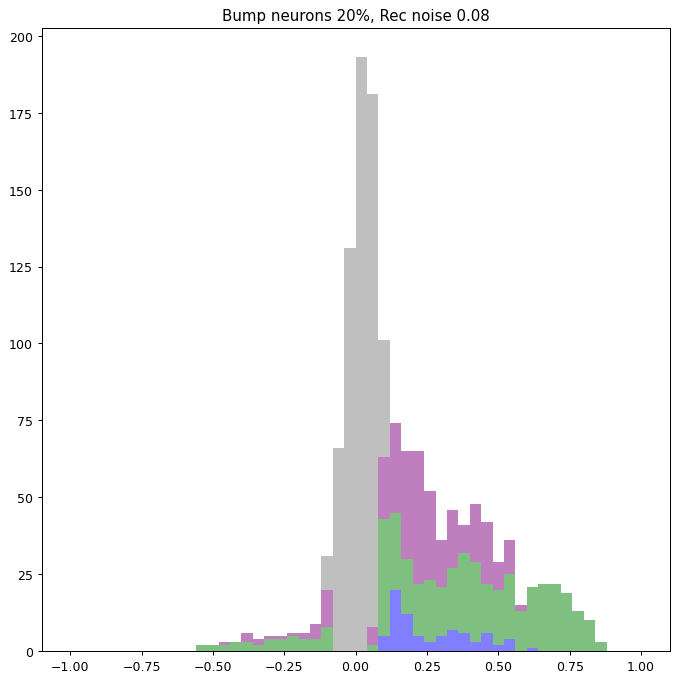

In [18]:
histogram_xrange = [-1,1]
for data_folder in data_folder_list:
    print(data_folder)
    for epoch in ['']:
        print("Epoch: ", epoch)
        for bump_percen in bump_percen_range:
            N_rec1 = int(bump_population/bump_percen) # Number of neurons for region1 
            non_bump_population1 = N_rec1-bump_population # number of non-bump neurons in region1
#             print('Epoch:', epoch)
            model_name = 'bump'+str(bump_percen)+"_"+str(N_rec1)+'Nrec_'
            print(model_name)
            for significance_level in significance_level_range:
                for tau in tau_range:
                    dt = int(tau*dt_percentage[tau])
                    # set timebins of the second part of delay1 
                    time_window = [18, 28]
                    delay1_size = 2*(time_window[1]-time_window[0])
                    for input_sigma in input_sigma_range:
                        for recurrent_noise in recurrent_noise_range: 
                            for inter_connect_percen in inter_connect_percen_range:
                                for inner_connect_percen in inner_connect_percen_range:
                                    params_values = '/stimulus'+str(outputs)+'/dt'+str(dt)+'/tau'+str(tau)+'/input-noise'+str(input_sigma)+'/rec-noise'+str(recurrent_noise)+'/inter-connect'+str(inter_connect_percen)+'/inner-connect'+str(inner_connect_percen)+'/'
                                    print(params_values)
                                    for region in ['FEF']:#['FEF', 'DLPFC']:
                                        print(region)
                                        pairs1 = []
                                        pairs2 = []
                                        pairs3 = []
                                        pair_correlations1 = [] # for bump pair neurons
                                        pair_correlations2 = [] # for non bump pair neurons
                                        pair_correlations3 = [] # for bump-non bump pair neurons
                                        p_values1 = []
                                        p_values2 = []
                                        p_values3 = []

                                        bump_spike_rates=[]
                                        non_bump_spike_rates = []
                                        for model_version in model_version_range:
                                            print(model_name, model_version)
                                            session_contributions = []
                                            for session in np.arange(len(monkey_session_data[region])):
                                                print('Session: ', session)
                                                session_contribution = monkey_session_data[region][session][1]
        #                                         print(session_contribution)
                                                pair_correlations = []
                                                p_values_lists = []
                                                checked_pairs = []
                                                checked_singles = []
                                                checked_singles2 = []

                                                session_selective = []
                                                selective_combinations = []
                                                # Load datasets
                                                data = dataset[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)]
                                                data_labels = np.argmax(dataset_labels[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)],
                                                                                axis=1)+1
                                                data_output = dataset_output[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)]
                                                data_gt = dataset_gt[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)]
                                                data_mask = dataset_mask[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)]
                                                print("Session trials: ", data.shape[0])
                                                # keep only correct trials
                                                correct_trials = get_correct_trials(data_gt, data_output, data_mask)
                                                data = data[correct_trials,:,:]
                                                data_labels = data_labels[correct_trials]
                                                if np.unique(data_labels).size<=1:
                                                    print("Skipp session, correct data labels only for 1 class!")
                                                    continue

                                                stiched_trial_window_size = 2*(time_window[1]-time_window[0])


                                                zscored_data = zscore_dataset(data[:, time_window[1]-delay1_size:time_window[1], :], data_labels)


                                                selective = get_neuron_selectivity(data[:, time_window[0]:time_window[1], :],
                                                                                   data_labels, method=method,
                                                                                   anova_significance_p=significance_level, ttest_significance_p=significance_level,
                                                                                   prestim_dataset=data[:, 0:2, :])
                                                for key_stim in selective.keys():
                                                    # find all the selective neurons combinations to iterate through
                                                    selective_combinations+=list(combinations(selective[key_stim],2))
                                                print('Selective Combinations: ',len(selective_combinations))
                                                if selective_combinations:
                                                    pair_mapping = []
                                                    for pair in selective_combinations:
                                                        if pair not in checked_pairs:# and np.mod(np.abs(pair[0]-pair[1]),79)<2:
                                                            # find the overlapping locations of the pair cells
                                                            overlaping_locs = [loc for loc in find_selective_locations(pair[0], pair[1], selective)]
                                                            if len(overlaping_locs)!=0:
                                                                # filter locations based on firing rates of the pair neurons
                                                                filtered_locs = defaultdict(list)
                                                                for cell in pair:
                                                                    for lc in overlaping_locs:
                                                                        if cell<bump_population:
                                                                                filtered_locs[cell].append(lc)
                                                                        else:
                                                                                filtered_locs[cell].append(lc)

                                                                common_locs = set(filtered_locs[pair[0]]).intersection(filtered_locs[pair[1]])
                                                                if common_locs:
                                                                    all_trials = np.array([])
                                                                    for all_loc in common_locs:
                                                                        all_trials = np.concatenate([all_trials,np.where(data_labels==all_loc)[0]])
                                                                    all_trials = all_trials.astype(int) 
                                                                    stiched_zscored_neuron_trials = np.zeros((2, stiched_trial_window_size*all_trials.shape[0]))
                                                                    for n, neuron in enumerate(pair):
                                                                        stiched_zscored_neuron_trials[n, :] = zscored_data[all_trials, :, neuron].reshape(-1)

                                                                    if bump_percen ==0:
                                                                        pair_mapping.append(2)
                                                                    elif bump_percen ==1:
                                                                        pair_mapping.append(1)
                                                                    else:
                                                                        pair_mapping.append(1 if (pair[0]<bump_population and pair[1]<bump_population) else (2 if (pair[0]>=bump_population and pair[1]>=bump_population) else 3))

                                                                    # find the nan valued trials after zscoring and exclude them from the calculation of correlation 
                                                                    nan_idxs = np.concatenate([np.where(np.isnan(stiched_zscored_neuron_trials[0,:]))[0],
                                                                                    np.where(np.isnan(stiched_zscored_neuron_trials[1,:]))[0]])
                                                                    mask=np.full(stiched_zscored_neuron_trials.shape[1], True)
                                                                    mask[nan_idxs]=False
                                                                    pcis, p_values = stats.pearsonr(stiched_zscored_neuron_trials[0, mask],stiched_zscored_neuron_trials[1, mask])
                                                                    pair_correlations.append(pcis)
                                                                    p_values_lists.append(p_values)
                                                                    checked_pairs.append(pair)
                                                                    for neuron in pair:
                                                                        if neuron not in checked_singles2:
                                                                            checked_singles2.append(neuron)
                                                                            if session in [1,2] and region == 'FEF':
                                                                                all_neurons[data_folder+params_values+model_name+'epoch'+str(epoch)].append(data[all_trials, time_window[1]-delay1_size:time_window[1], neuron])
                                                                                all_neurons_labels[data_folder+params_values+model_name+'epoch'+str(epoch)].append(neuron)

                                                    # keep all pairs and their correlations for each model version to
                                                    # use in temporal decoding based on percentile of correlations histogram
                                                    version_pairs_region1[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)] = checked_pairs
                                                    version_correlations_region1[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)] = pair_correlations
                                                    version_pvalues_region1[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)] = p_values_lists

                                                    # keep only from 1 session and 1 region for each model version
                                                    if session == 0 and region == 'FEF': 
                                                        pairs1.append(np.array(checked_pairs)[np.where(np.array(pair_mapping)==1)]+(N_rec1*model_version))
                                                        pairs2.append(np.array(checked_pairs)[np.where(np.array(pair_mapping)==2)]+(N_rec1*model_version))
                                                        pairs3.append(np.array(checked_pairs)[np.where(np.array(pair_mapping)==3)]+(N_rec1*model_version))

                                                        pair_correlations1.append(list(np.array(pair_correlations)[np.where(np.array(pair_mapping)==1)]))
                                                        pair_correlations2.append(list(np.array(pair_correlations)[np.where(np.array(pair_mapping)==2)]))
                                                        pair_correlations3.append(list(np.array(pair_correlations)[np.where(np.array(pair_mapping)==3)]))
                                                        p_values1.append(list(np.array(p_values_lists)[np.where(np.array(pair_mapping)==1)]))
                                                        p_values2.append(list(np.array(p_values_lists)[np.where(np.array(pair_mapping)==2)]))
                                                        p_values3.append(list(np.array(p_values_lists)[np.where(np.array(pair_mapping)==3)]))
                                                # add selectivity contribution for all sessions
                                                selective_neurons = len(np.unique(np.array(checked_pairs)))
                                                session_selectivity = selective_neurons/data.shape[-1]
                                                session_contributions.append( session_selectivity*session_contribution )
                                                print("Session Selective neuron: ",selective_neurons)
                                                print("Session selectivity: ", session_selectivity)
                                                print("Session contribution: ", session_contributions[-1])
                                            
                                            # Save the model selectivity percentage according to the weighted selectivity contributions
                                            model_percentages[data_folder+params_values+model_name+'epoch'+str(epoch)].append( np.sum(session_contributions) )
                                        # format data for plotting
                                        flatten_pairs1 = np.array([item for sublist in pairs1 for item in sublist])
                                        flatten_pairs2 = np.array([item for sublist in pairs2 for item in sublist])
                                        flatten_pairs3 = np.array([item for sublist in pairs3 for item in sublist])

                                        flatten_pair_correlations1 = np.array([item for sublist in pair_correlations1 for item in sublist])
                                        flatten_pair_correlations2 = np.array([item for sublist in pair_correlations2 for item in sublist])
                                        flatten_pair_correlations3 = np.array([item for sublist in pair_correlations3 for item in sublist])
                                        flatten_p_values1 = np.array([item for sublist in p_values1 for item in sublist])
                                        flatten_p_values2 = np.array([item for sublist in p_values2 for item in sublist])
                                        flatten_p_values3 = np.array([item for sublist in p_values3 for item in sublist])

                                        pair_corr_bump_low = flatten_pair_correlations1[np.where(flatten_p_values1<p_value_threshold)]
                                        pair_corr_bump_high = flatten_pair_correlations1[np.where(flatten_p_values1>=p_value_threshold)]

                                        pair_corr_nonbump_low = flatten_pair_correlations2[np.where(flatten_p_values2<p_value_threshold)]
                                        pair_corr_nonbump_high = flatten_pair_correlations2[np.where(flatten_p_values2>p_value_threshold)]

                                        pair_corr_mix_low = flatten_pair_correlations3[np.where(flatten_p_values3<p_value_threshold)]
                                        pair_corr_mix_high = flatten_pair_correlations3[np.where(flatten_p_values3>p_value_threshold)]                                                       

                                        bump_spike_rates_flat = np.array([item for sublist in bump_spike_rates for item in sublist])
                                        non_bump_spike_rates_flat = np.array([item for sublist in non_bump_spike_rates for item in sublist])

                                        all_high_p_value_pairs = np.concatenate([pair_corr_bump_high, pair_corr_nonbump_high, pair_corr_mix_high])

                                        print("Pairs: ", pair_corr_bump_low.shape[0]+pair_corr_nonbump_low.shape[0]+pair_corr_mix_low.shape[0]+all_high_p_value_pairs.shape[0])

                                        plt.figure(figsize=(9, 9), dpi=90)
                                        yy,__,__ = plt.hist([pair_corr_bump_low, pair_corr_nonbump_low,
                                                            pair_corr_mix_low, all_high_p_value_pairs], color=['blue','green', 'purple', 'grey'], bins=hist_bins, stacked=True, alpha=0.5, range=[histogram_xrange[0], histogram_xrange[1]],
                                                            label=['Bump Pairs, p-value < '+str(p_value_threshold),
                                                                   'Non-Bump Pairs, p-value < '+str(p_value_threshold),
                                                                   'Mixed Pairs, p-value < '+str(p_value_threshold),
                                                                   'p-value > '+str(p_value_threshold)])
                                        plt.title('Bump neurons '+str(int(bump_percen*100))+'%, Rec noise '+str(recurrent_noise))
                                        plt.show()
                                        # save correlation data to be able to replot each model individually
                                        model_plot_pairs_bump_low[data_folder+params_values+model_name+'epoch'+str(epoch)] = pair_corr_bump_low
                                        model_plot_pairs_nonbump_low[data_folder+params_values+model_name+'epoch'+str(epoch)] = pair_corr_nonbump_low
                                        model_plot_pairs_corr_mix_low[data_folder+params_values+model_name+'epoch'+str(epoch)] = pair_corr_mix_low
                                        model_plot_all_high_p_value_pairs[data_folder+params_values+model_name+'epoch'+str(epoch)] = all_high_p_value_pairs



# Selectivity Percentages BoxPlots

Tau:  200
exploring-inner-connection-of-datasets


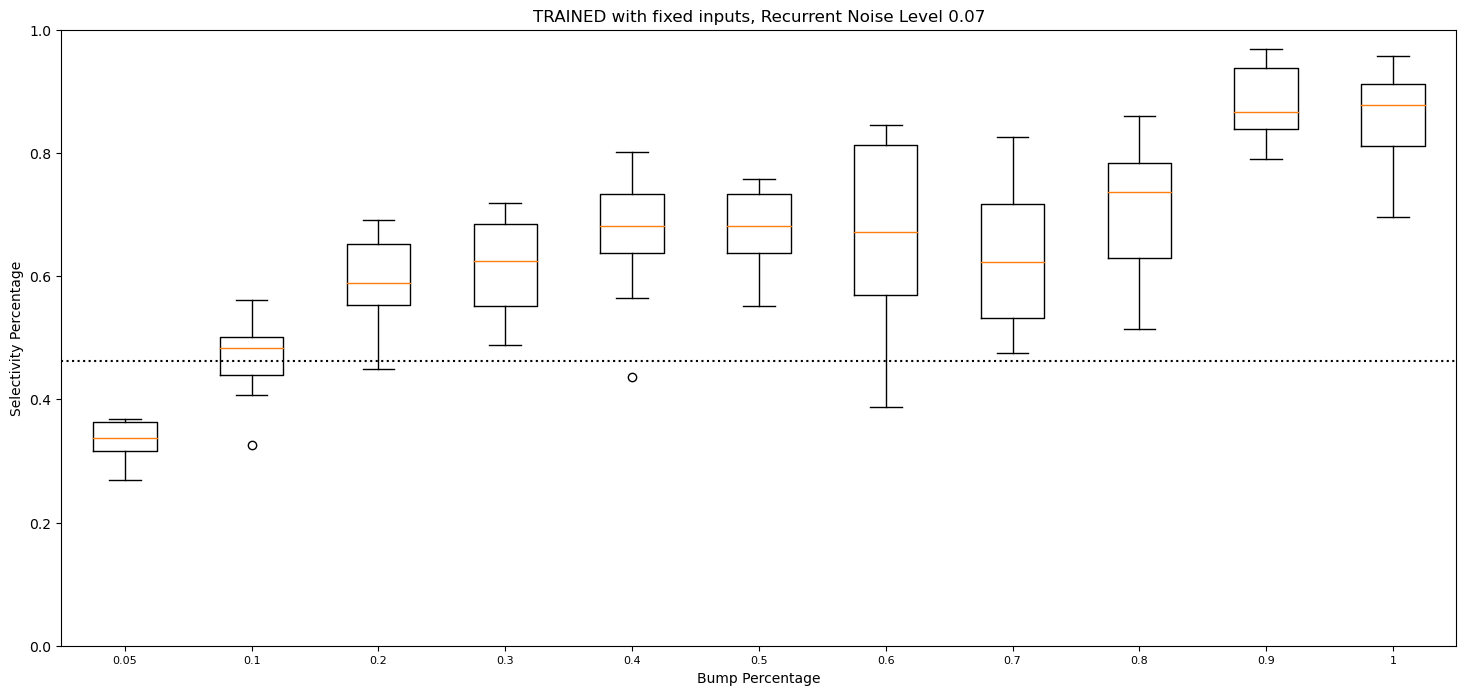

Tau:  200
exploring-inner-connection-of-datasets


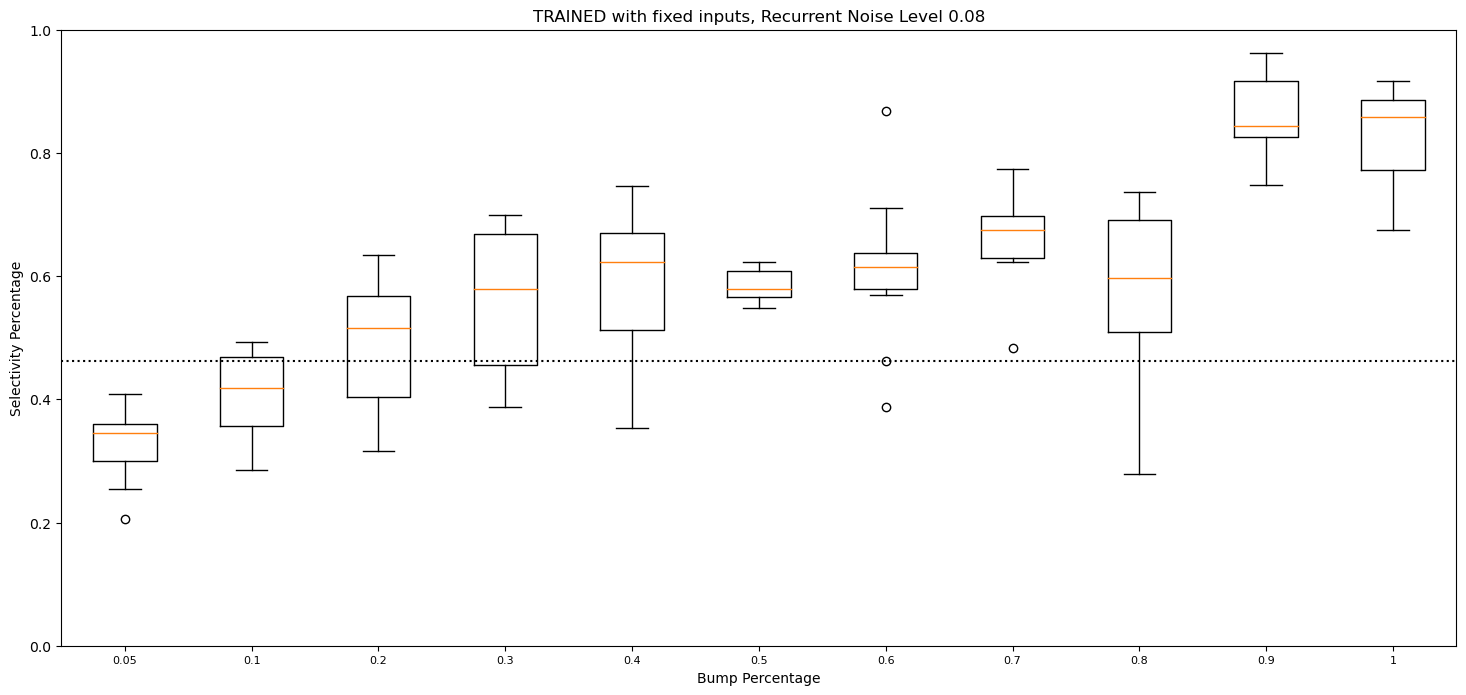

Tau:  200
exploring-inner-connection-of-datasets


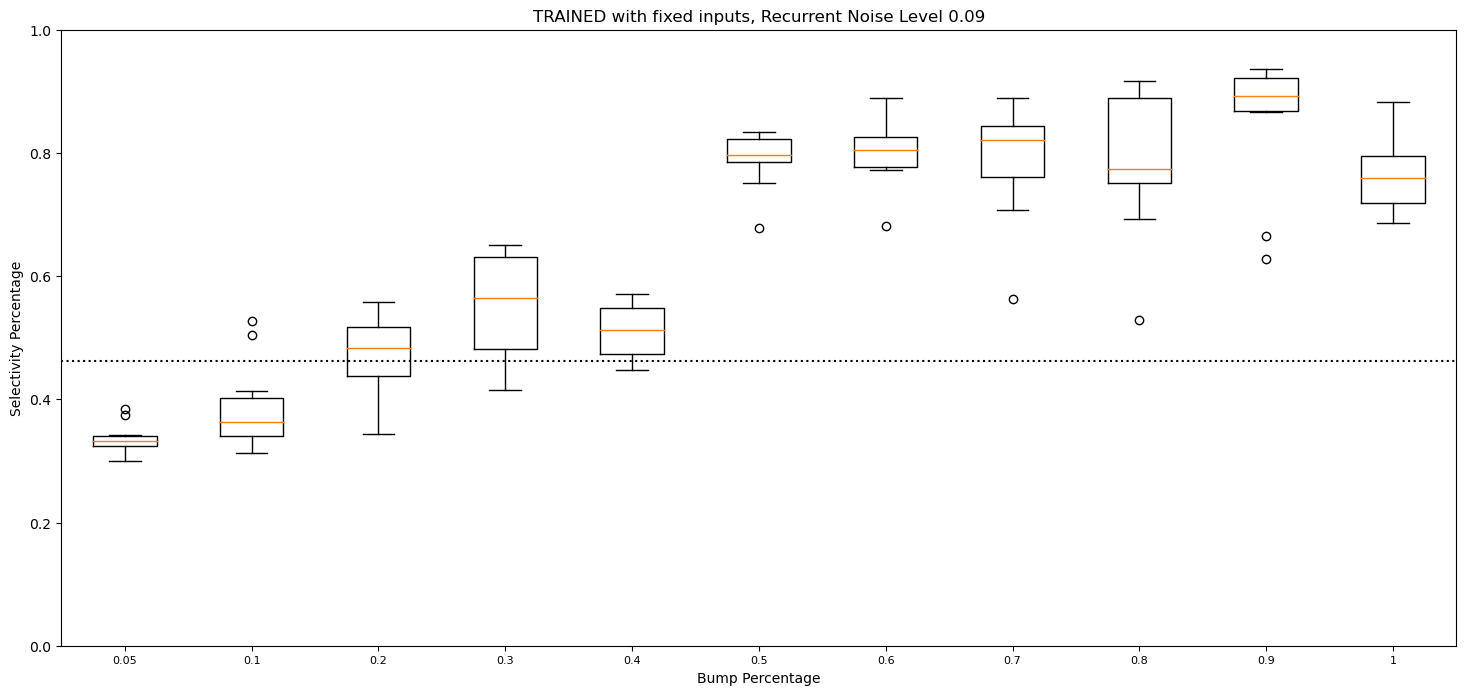

In [65]:
for r, recurrent_noise in enumerate(recurrent_noise_range):
    selective_percentages_fef = []

    x_axis = []
    for tau in tau_range:
        print('Tau: ', tau)
        dt = int(tau*dt_percentage[tau])
        for data_folder in data_folder_list:
            print(data_folder)
            for epoch in ['']:
                for bump_percen in bump_percen_range:
                    if bump_percen == 0:
                        N_rec1 = bump_population#120
                    elif bump_percen == 1:
                        N_rec1 = bump_population
                    else:
                        N_rec1 = int(bump_population/bump_percen) # Number of neurons for region1 
                        non_bump_population1 = N_rec1-bump_population # number of non-bump neurons in region1
                    model_name = 'bump'+str(bump_percen)+"_"+str(N_rec1)+'Nrec_'
        #             print(model_name)
                    for significance_level in significance_level_range:
                        for input_sigma in input_sigma_range:
                            for inter_connect_percen in inter_connect_percen_range:
                                for inner_connect_percen in inner_connect_percen_range:
                                    params_values = '/stimulus'+str(outputs)+'/dt'+str(dt)+'/tau'+str(tau)+'/input-noise'+str(input_sigma)+'/rec-noise'+str(recurrent_noise)+'/inter-connect'+str(inter_connect_percen)+'/inner-connect'+str(inner_connect_percen)+'/'
                                    x_axis.append(bump_percen)
                                    selective_percentages_fef.append(model_percentages[data_folder+params_values+model_name+'epoch'+str(epoch)])
#     
    plt.figure(figsize=(18,8))

    full_space = np.arange(len(selective_percentages_fef))

    plt.boxplot(selective_percentages_fef, positions=full_space)
    plt.title('TRAINED with fixed inputs, Recurrent Noise Level '+str(recurrent_noise))

    plt.xticks(full_space, x_axis, fontsize=8)
    plt.ylabel("Selectivity Percentage")
    plt.xlabel("Bump Percentage")

    plt.axhline(y = 61/132, color = 'red', linestyle = 'dotted', label='FEF percentage')

    plt.ylim([0,1])
    plt.show()


# Subsampling each model session

In [20]:
model_significant_neuron_percentages = defaultdict(list)
model_significant_pair_percentages = defaultdict(list)
model_total_significant_non_bump_neuron = defaultdict(list)
model_total_significant_bump_neuron = defaultdict(list)
model_total_non_significant_non_bump_neuron = defaultdict(list)
model_total_non_significant_bump_neuron = defaultdict(list)


datasets
Epoch:  
bump0.2_180Nrec_
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/
FEF
bump0.2_180Nrec_ 0
Session:  0
Session trials:  480
Selective Combinations:  28
Session Selective neuron:  9
Session selectivity:  0.375
Session contribution:  0.008522727272727272
Session:  1
Session trials:  480
Selective Combinations:  7
Session Selective neuron:  5
Session selectivity:  0.20833333333333334
Session contribution:  0.01893939393939394
Session:  2
Session trials:  360
Selective Combinations:  18
Session Selective neuron:  6
Session selectivity:  0.35294117647058826
Session contribution:  0.010695187165775402
Session:  3
Session trials:  360
Selective Combinations:  16
Session Selective neuron:  8
Session selectivity:  0.47058823529411764
Session contribution:  0.028520499108734405
Session:  4
Session trials:  440
Selective Combinations:  31
Session Selective neuron:  11
Session selectivity:  0.5789473684210527
Session contribution:  0.0087719298

/home/e/esigalas/anaconda3/envs/neuronal_models/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3757: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/e/esigalas/anaconda3/envs/neuronal_models/lib/python3.8/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Session:  9
Session trials:  240
Selective Combinations:  0
Session Selective neuron:  0
Session selectivity:  0.0
Session contribution:  0.0
Session:  10
Session trials:  360
Selective Combinations:  6
Session Selective neuron:  3
Session selectivity:  0.2727272727272727
Session contribution:  0.002066115702479339
Session:  11
Session trials:  360
Selective Combinations:  2
Session Selective neuron:  2
Session selectivity:  0.18181818181818182
Session contribution:  0.009641873278236915
Session:  12
Session trials:  240
Selective Combinations:  12
Session Selective neuron:  4
Session selectivity:  0.26666666666666666
Session contribution:  0.006060606060606061
Session:  13
Session trials:  240
Selective Combinations:  22
Session Selective neuron:  8
Session selectivity:  0.5333333333333333
Session contribution:  0.03636363636363636
Session:  14
Session trials:  200
Selective Combinations:  5
Session Selective neuron:  5
Session selectivity:  0.5555555555555556
Session contribution:  0

/home/e/esigalas/anaconda3/envs/neuronal_models/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/e/esigalas/anaconda3/envs/neuronal_models/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


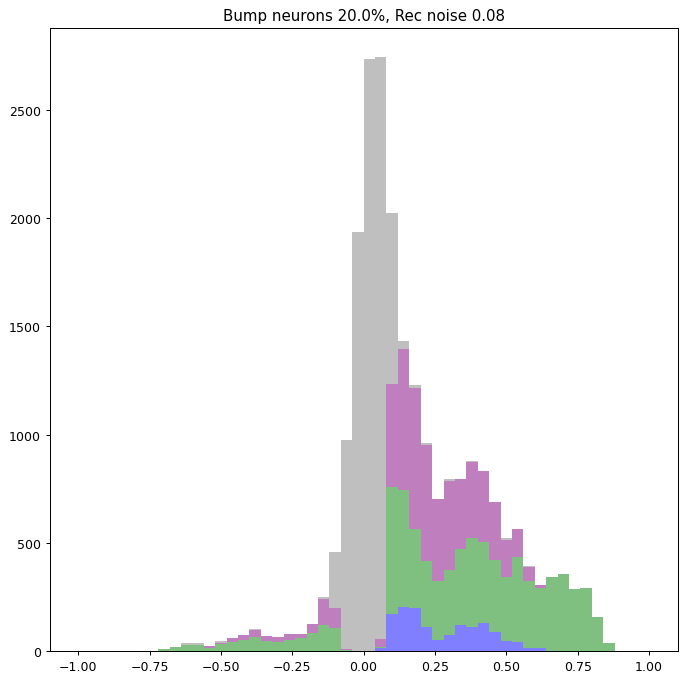

In [21]:
histogram_xrange = [-1,1]
subsampling_iterations = 100
for data_folder in data_folder_list:
    print(data_folder)
    for epoch in ['']:
        print("Epoch: ", epoch)
        for bump_percen in bump_percen_range:
            N_rec1 = int(bump_population/bump_percen) # Number of neurons for region1 
            non_bump_population1 = N_rec1-bump_population # number of non-bump neurons in region1
#             print('Epoch:', epoch)
            model_name = 'bump'+str(bump_percen)+"_"+str(N_rec1)+'Nrec_'
            print(model_name)
            for significance_level in significance_level_range:
                for tau in tau_range:
                    dt = int(tau*dt_percentage[tau])
                    time_window = [18, 28]
                    delay1_size = 2*(time_window[1]-time_window[0])
                    for input_sigma in input_sigma_range:
                        for recurrent_noise in recurrent_noise_range: 
                            for inter_connect_percen in inter_connect_percen_range:
                                for inner_connect_percen in inner_connect_percen_range:
                                    params_values = '/stimulus'+str(outputs)+'/dt'+str(dt)+'/tau'+str(tau)+'/input-noise'+str(input_sigma)+'/rec-noise'+str(recurrent_noise)+'/inter-connect'+str(inter_connect_percen)+'/inner-connect'+str(inner_connect_percen)+'/'
                                    print(params_values)
                                    for region in ['FEF']:
                                        print(region)
                                        pairs1 = []
                                        pairs2 = []
                                        pairs3 = []
                                        pair_correlations1 = [] # for bump pair neurons
                                        pair_correlations2 = [] # for non bump pair neurons
                                        pair_correlations3 = [] # for bump-non bump pair neurons
                                        p_values1 = []
                                        p_values2 = []
                                        p_values3 = []

                                        bump_spike_rates=[]
                                        non_bump_spike_rates = []
                                        for model_version in model_version_range:
                                            print(model_name, model_version)
                                            session_contributions = []
                                            session_significant_neurons = []
                                            session_number_of_neurons = []

                                            session_significant_pairs = []
                                            session_number_of_pairs = []
                                            total_significant_non_bump_neurons = 0
                                            total_significant_bump_neurons = 0
                                            total_non_significant_non_bump_neurons = 0
                                            total_non_significant_bump_neurons = 0
                                            for session in np.arange(len(monkey_session_data[region])):
                                                print('Session: ', session)
                                                session_contribution = monkey_session_data[region][session][1]
                                                session_neurons = monkey_session_data[region][session][2]
        #                                         print(session_contribution)
                                                for subsampling_iteration in np.arange(subsampling_iterations):
                                                    pair_correlations = []
                                                    p_values_lists = []
                                                    checked_pairs = []
                                                    checked_singles = []
                                                    checked_singles2 = []

                                                    session_selective = []
                                                    selective_combinations = []
                                                    # Load datasets
                                                    data = dataset[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)]
                                                    data_labels = np.argmax(dataset_labels[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)],
                                                                                    axis=1)+1
                                                    data_output = dataset_output[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)]
                                                    data_gt = dataset_gt[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)]
                                                    data_mask = dataset_mask[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)]
                                                    if subsampling_iteration == 0:
                                                        print("Session trials: ", data.shape[0])
                                                    # keep only correct trials
                                                    correct_trials = get_correct_trials(data_gt, data_output, data_mask)

                                                    data = data[correct_trials,:,:]
                                                    # subsample the model neuron population to match the monkey data session
                                                    subsampled_indices = np.random.choice(data.shape[-1], session_neurons, replace=False)
                                                    data = data[:,:,subsampled_indices]
                                                    data_labels = data_labels[correct_trials]
                                                    if np.unique(data_labels).size<=1:
                                                        print("Skipp session, correct data labels only for 1 class!")
                                                        continue

                                                    stiched_trial_window_size = 2*(time_window[1]-time_window[0])

                                                    zscored_data = zscore_dataset(data[:, time_window[1]-delay1_size:time_window[1], :], data_labels)

                                                    selective = get_neuron_selectivity(data[:, time_window[0]:time_window[1], :],
                                                                                       data_labels, method=method,
                                                                                       anova_significance_p=significance_level, ttest_significance_p=significance_level,
                                                                                       prestim_dataset=data[:, 0:2, :])
                                                    for key_stim in selective.keys():
                                                        # find all the selective neurons combinations to iterate through
                                                        selective_combinations+=list(combinations(selective[key_stim],2))
                                                    if subsampling_iteration == 0:
                                                        print('Selective Combinations: ',len(selective_combinations))
                                                    if selective_combinations:
                                                        pair_mapping = []
                                                        for pair in selective_combinations:
                                                            if pair not in checked_pairs:
                                                                # find the overlapping locations of the pair cells
                                                                overlaping_locs = [loc for loc in find_selective_locations(pair[0], pair[1], selective)]
                                                                if len(overlaping_locs)!=0:
                                                                    # filter locations based on firing rates of the pair neurons
                                                                    filtered_locs = defaultdict(list)
                                                                    for cell in pair:
                                                                        spike_rate_per_location = []
                                                                        for lc in overlaping_locs:
                                                                            if cell<bump_population:
                                                                                    filtered_locs[cell].append(lc)
                                                                            else:
                                                                                    filtered_locs[cell].append(lc)

                                                                    common_locs = set(filtered_locs[pair[0]]).intersection(filtered_locs[pair[1]])
                                                                    if common_locs:
                                                                        all_trials = np.array([])
                                                                        for all_loc in common_locs:
                                                                            all_trials = np.concatenate([all_trials,np.where(data_labels==all_loc)[0]])
                                                                        all_trials = all_trials.astype(int) 
                                                                        stiched_zscored_neuron_trials = np.zeros((2, stiched_trial_window_size*all_trials.shape[0]))
                                                                        for n, neuron in enumerate(pair):
                                                                            stiched_zscored_neuron_trials[n, :] = zscored_data[all_trials, :, neuron].reshape(-1)

                                                                        if bump_percen ==0:
                                                                            pair_mapping.append(2)
                                                                        elif bump_percen ==1:
                                                                            pair_mapping.append(1)
                                                                        else:
#                                                                             pair_mapping.append(1 if (pair[0]<bump_population and pair[1]<bump_population) else (2 if (pair[0]>=bump_population and pair[1]>=bump_population) else 3))
                                                                            pair_mapping.append(1 if (subsampled_indices[pair[0]]<bump_population and subsampled_indices[pair[1]]<bump_population) else (2 if (subsampled_indices[pair[0]]>=bump_population and subsampled_indices[pair[1]]>=bump_population) else 3))

                                                                        # find the nan valued trials after zscoring and exclude them from the calculation of correlation 
                                                                        nan_idxs = np.concatenate([np.where(np.isnan(stiched_zscored_neuron_trials[0,:]))[0],
                                                                                        np.where(np.isnan(stiched_zscored_neuron_trials[1,:]))[0]])
                                                                        mask=np.full(stiched_zscored_neuron_trials.shape[1], True)
                                                                        mask[nan_idxs]=False
                                                                        pcis, p_values = stats.pearsonr(stiched_zscored_neuron_trials[0, mask],stiched_zscored_neuron_trials[1, mask])
                                                                        pair_correlations.append(pcis)
                                                                        p_values_lists.append(p_values)
                                                                        checked_pairs.append(pair)

                                                        # keep only from 1 session and 1 region for each model version 
                                                        if region == 'FEF':
                                                            pairs1.append(np.array(checked_pairs)[np.where(np.array(pair_mapping)==1)]+(N_rec1*len(model_version_range)*len(monkey_session_data[region])))#(N_rec1*model_version))
                                                            pairs2.append(np.array(checked_pairs)[np.where(np.array(pair_mapping)==2)]+(N_rec1*len(model_version_range)*len(monkey_session_data[region])))
                                                            pairs3.append(np.array(checked_pairs)[np.where(np.array(pair_mapping)==3)]+(N_rec1*len(model_version_range)*len(monkey_session_data[region])))

                                                            pair_correlations1.append(list(np.array(pair_correlations)[np.where(np.array(pair_mapping)==1)]))
                                                            pair_correlations2.append(list(np.array(pair_correlations)[np.where(np.array(pair_mapping)==2)]))
                                                            pair_correlations3.append(list(np.array(pair_correlations)[np.where(np.array(pair_mapping)==3)]))
                                                            p_values1.append(list(np.array(p_values_lists)[np.where(np.array(pair_mapping)==1)]))
                                                            p_values2.append(list(np.array(p_values_lists)[np.where(np.array(pair_mapping)==2)]))
                                                            p_values3.append(list(np.array(p_values_lists)[np.where(np.array(pair_mapping)==3)]))

                                                    # calculate significant neurons and pairs
                                                    significant_pairs = np.array(checked_pairs)[np.where(np.array(p_values_lists)<significance_level)[0]]
                                                    non_significant_pairs = np.array(checked_pairs)[np.where(np.array(p_values_lists)>=significance_level)[0]]

                                                    significant_neurons = np.unique(significant_pairs)
                                                    non_significant_neurons = np.unique(non_significant_pairs)

                                                    significant_neurons_number =  len(significant_neurons)
                                                    non_significant_neurons_number = len(non_significant_neurons)
                                                    
                                                    significant_pairs_number = len(significant_pairs)
                                                    non_significant_pairs_number = len(non_significant_pairs)
                                                    
                                                    original_neuron_indices_significant = np.array([subsampled_indices[n_] for n_ in significant_neurons])
                                                    total_significant_non_bump_neurons += np.where(original_neuron_indices_significant>=bump_population)[0].shape[0]
                                                    total_significant_bump_neurons += np.where(original_neuron_indices_significant<bump_population)[0].shape[0]
                                                    
                                                    original_neuron_indices_non_significant = np.array([subsampled_indices[n_] for n_ in non_significant_neurons])
                                                    total_non_significant_non_bump_neurons += np.where(original_neuron_indices_non_significant>=bump_population)[0].shape[0]
                                                    total_non_significant_bump_neurons += np.where(original_neuron_indices_non_significant<bump_population)[0].shape[0]
                                                    
                                                    session_significant_neurons.append(significant_neurons_number)
                                                    session_number_of_neurons.append(len(np.unique(checked_pairs)))
                                                    session_significant_pairs.append(significant_pairs_number)
                                                    session_number_of_pairs.append(len(checked_pairs))
                                                    
                                                    if subsampling_iteration == 0:
                                                        # add selectivity contribution for all sessions
                                                        selective_neurons = len(np.unique(np.array(checked_pairs)))
                                                        session_selectivity = selective_neurons/data.shape[-1]
                                                        session_contributions.append( session_selectivity*session_contribution )
                                                        print("Session Selective neuron: ",selective_neurons)
                                                        print("Session selectivity: ", session_selectivity)
                                                        print("Session contribution: ", session_contributions[-1])
                                                
#                                             model_percentages[data_folder+params_values+model_name+'epoch'+str(epoch)].append( np.sum(session_contributions) )
                                            model_significant_neuron_percentages[data_folder+params_values+model_name+'epoch'+str(epoch)].append(np.sum(session_significant_neurons)/np.sum(session_number_of_neurons))
                                            model_significant_pair_percentages[data_folder+params_values+model_name+'epoch'+str(epoch)].append(np.sum(session_significant_pairs)/np.sum(session_number_of_pairs))
                                            model_total_significant_non_bump_neuron[data_folder+params_values+model_name+'epoch'+str(epoch)].append(total_significant_non_bump_neurons)
                                            model_total_significant_bump_neuron[data_folder+params_values+model_name+'epoch'+str(epoch)].append(total_significant_bump_neurons)
                                            model_total_non_significant_non_bump_neuron[data_folder+params_values+model_name+'epoch'+str(epoch)].append(total_non_significant_non_bump_neurons)
                                            model_total_non_significant_bump_neuron[data_folder+params_values+model_name+'epoch'+str(epoch)].append(total_non_significant_bump_neurons)

                                        flatten_pairs1 = np.array([item for sublist in pairs1 for item in sublist])
                                        flatten_pairs2 = np.array([item for sublist in pairs2 for item in sublist])
                                        flatten_pairs3 = np.array([item for sublist in pairs3 for item in sublist])

                                        flatten_pair_correlations1 = np.array([item for sublist in pair_correlations1 for item in sublist])
                                        flatten_pair_correlations2 = np.array([item for sublist in pair_correlations2 for item in sublist])
                                        flatten_pair_correlations3 = np.array([item for sublist in pair_correlations3 for item in sublist])
                                        flatten_p_values1 = np.array([item for sublist in p_values1 for item in sublist])
                                        flatten_p_values2 = np.array([item for sublist in p_values2 for item in sublist])
                                        flatten_p_values3 = np.array([item for sublist in p_values3 for item in sublist])

                                        pair_corr_bump_low = flatten_pair_correlations1[np.where(flatten_p_values1<p_value_threshold)]
                                        pair_corr_bump_high = flatten_pair_correlations1[np.where(flatten_p_values1>=p_value_threshold)]

                                        pair_corr_nonbump_low = flatten_pair_correlations2[np.where(flatten_p_values2<p_value_threshold)]
                                        pair_corr_nonbump_high = flatten_pair_correlations2[np.where(flatten_p_values2>p_value_threshold)]

                                        pair_corr_mix_low = flatten_pair_correlations3[np.where(flatten_p_values3<p_value_threshold)]
                                        pair_corr_mix_high = flatten_pair_correlations3[np.where(flatten_p_values3>p_value_threshold)]                                                       

                                        bump_spike_rates_flat = np.array([item for sublist in bump_spike_rates for item in sublist])
                                        non_bump_spike_rates_flat = np.array([item for sublist in non_bump_spike_rates for item in sublist])

                                        all_high_p_value_pairs = np.concatenate([pair_corr_bump_high, pair_corr_nonbump_high, pair_corr_mix_high])

                                        print("Pairs: ", pair_corr_bump_low.shape[0]+pair_corr_nonbump_low.shape[0]+pair_corr_mix_low.shape[0]+all_high_p_value_pairs.shape[0])

                                        plt.figure(figsize=(9, 9), dpi=90)
                                        yy,__,__ = plt.hist([pair_corr_bump_low, pair_corr_nonbump_low,
                                                            pair_corr_mix_low, all_high_p_value_pairs], color=['blue','green', 'purple', 'grey'], bins=hist_bins, stacked=True, alpha=0.5, range=[histogram_xrange[0], histogram_xrange[1]],
                                                            label=['Bump Pairs, p-value < '+str(p_value_threshold),
                                                                   'Non-Bump Pairs, p-value < '+str(p_value_threshold),
                                                                   'Mixed Pairs, p-value < '+str(p_value_threshold),
                                                                   'p-value > '+str(p_value_threshold)])
                                        plt.title('Bump neurons '+str(float(bump_percen*100))+'%, Rec noise '+str(recurrent_noise))

#                                         plt.legend(loc=2, fontsize=9)
                                        plt.show()

                                        model_plot_pairs_bump_low[data_folder+params_values+model_name+'epoch'+str(epoch)] = pair_corr_bump_low
                                        model_plot_pairs_nonbump_low[data_folder+params_values+model_name+'epoch'+str(epoch)] = pair_corr_nonbump_low
                                        model_plot_pairs_corr_mix_low[data_folder+params_values+model_name+'epoch'+str(epoch)] = pair_corr_mix_low
                                        model_plot_all_high_p_value_pairs[data_folder+params_values+model_name+'epoch'+str(epoch)] = all_high_p_value_pairs



# Signficant Neuron and Pair percentages boxplots

exploring-inner-connection-of-datasets


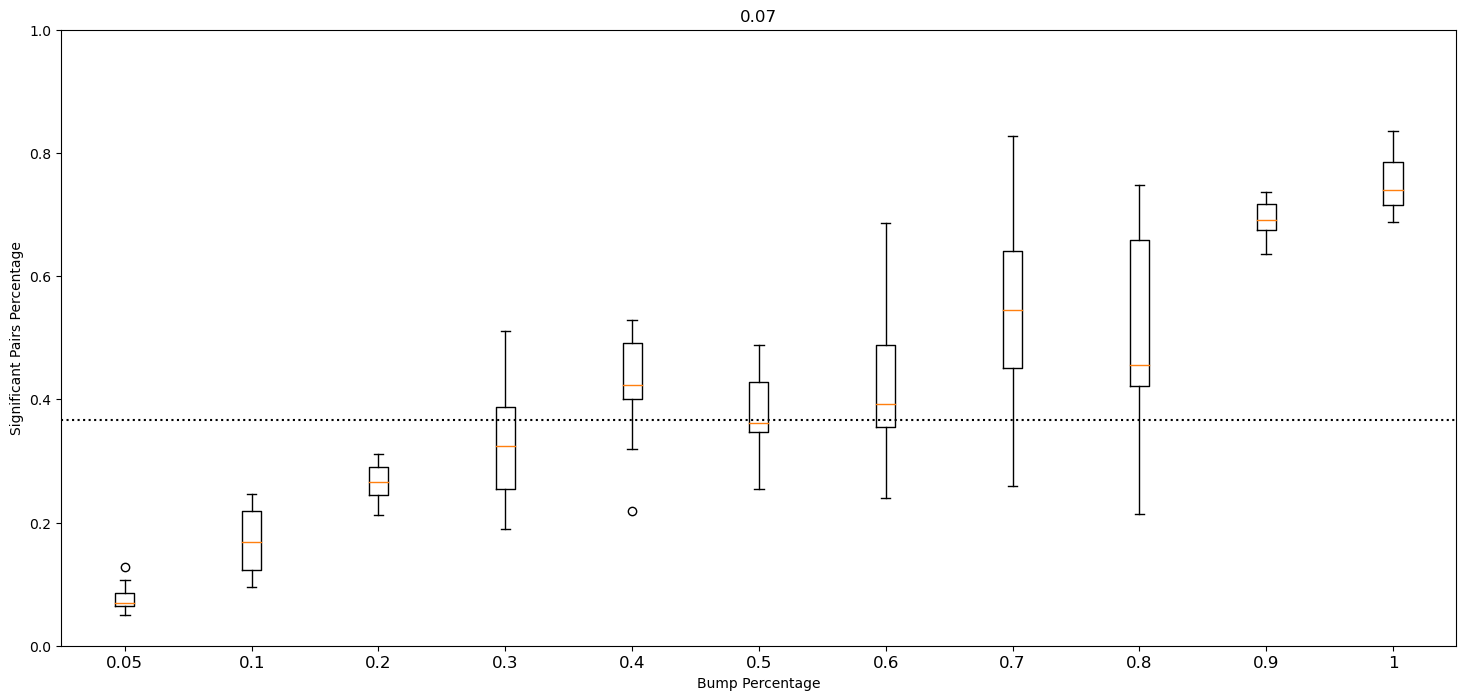

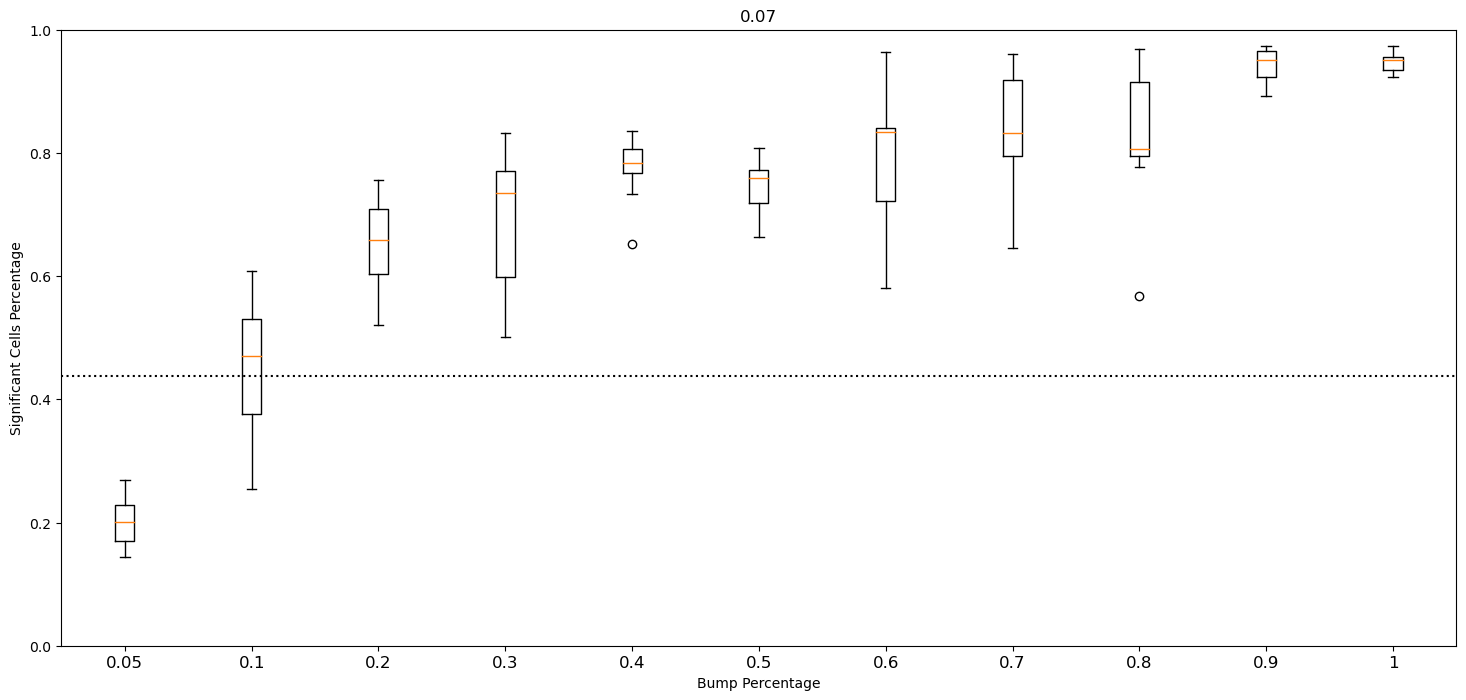

exploring-inner-connection-of-datasets


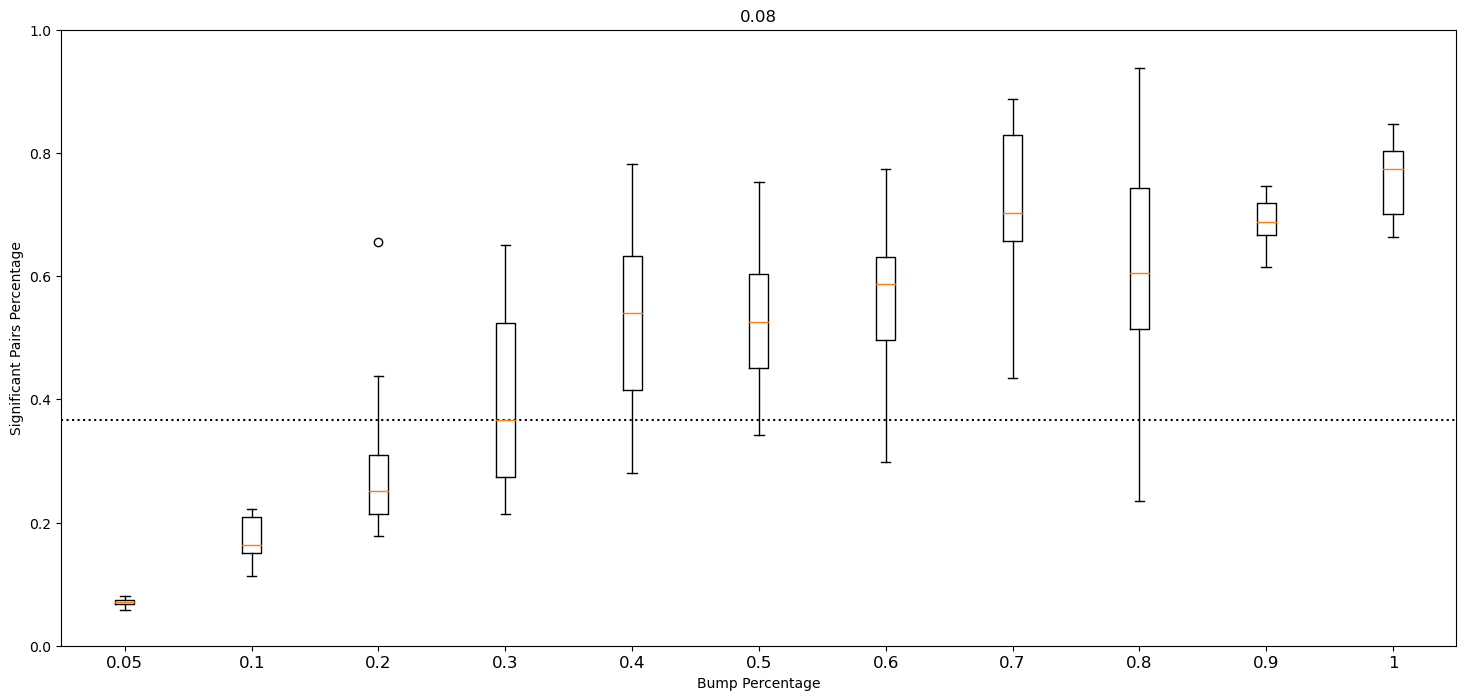

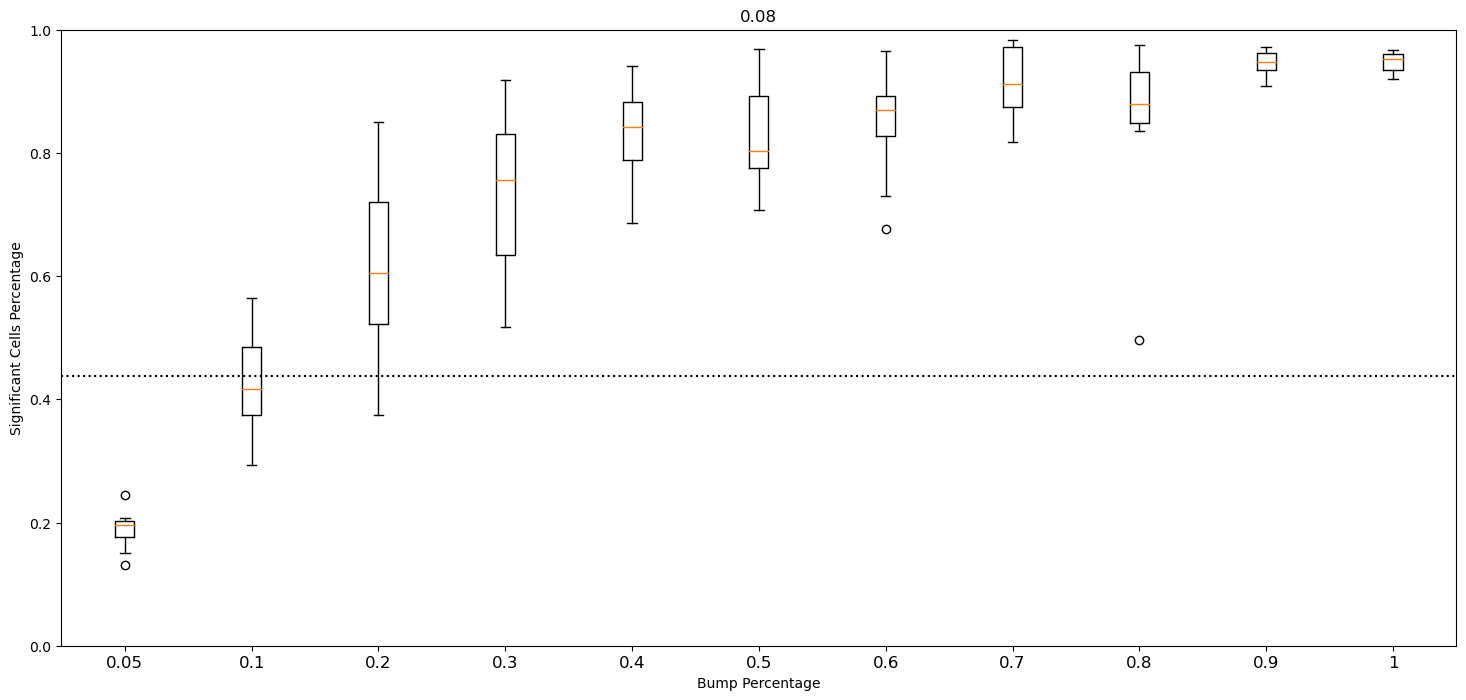

exploring-inner-connection-of-datasets


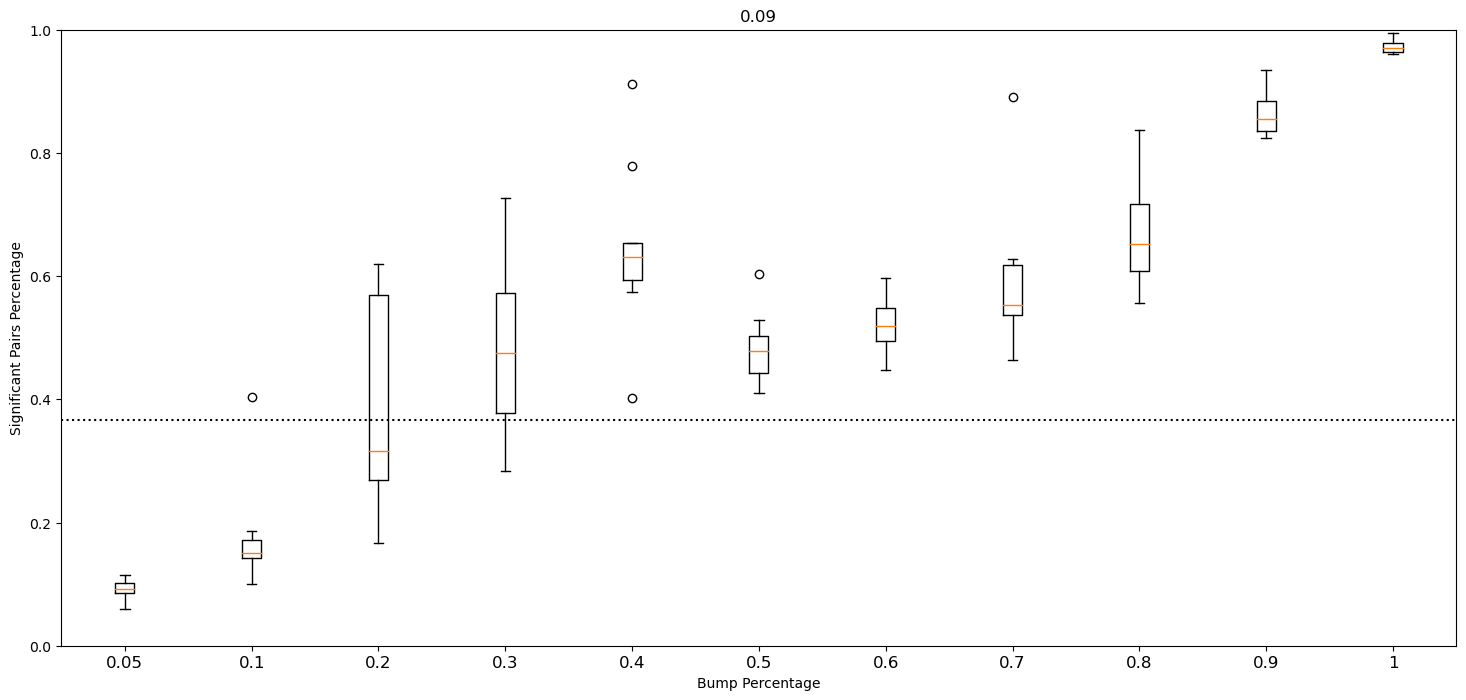

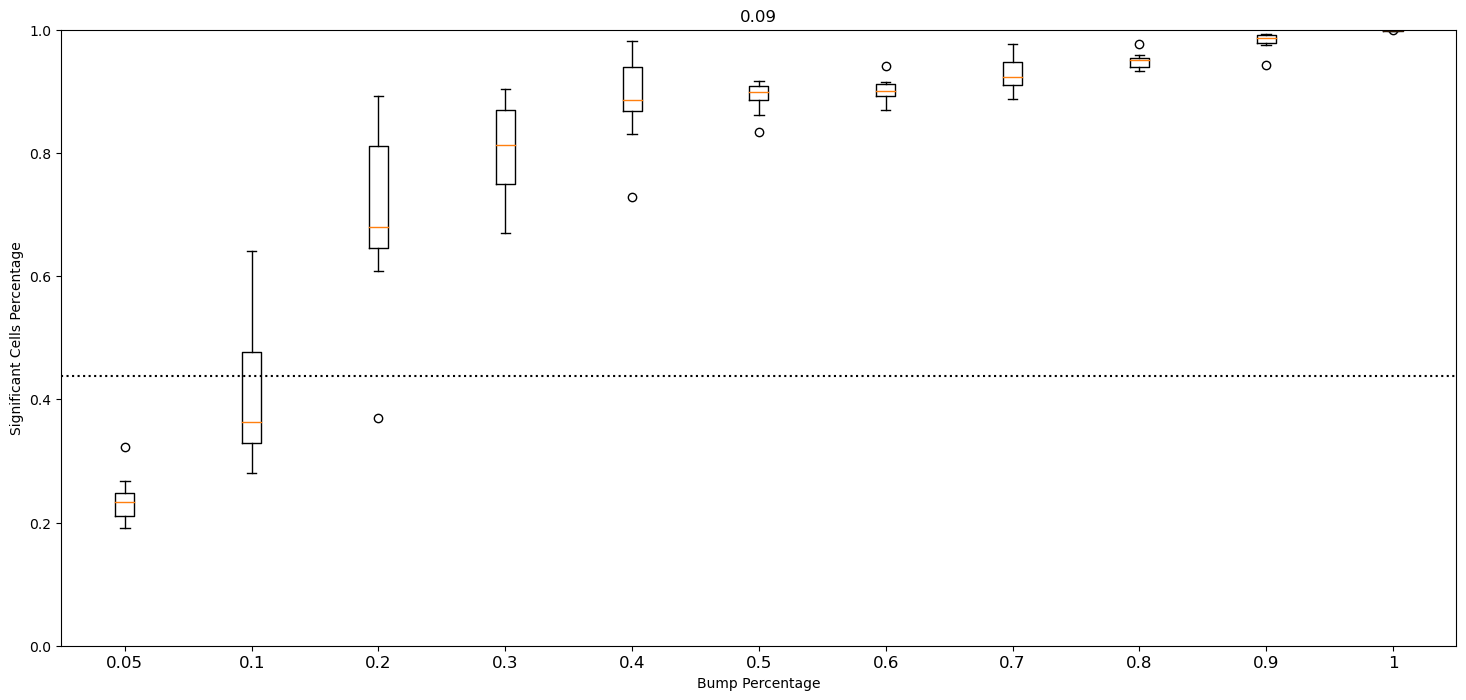

In [66]:
for r, recurrent_noise in enumerate(recurrent_noise_range):
    pair_percentages = defaultdict(list)
    correlations_means = defaultdict(list)
    cell_percentages = defaultdict(list)
    x_axis = []
    for data_folder in data_folder_list:
        print(data_folder)
        for epoch in ['']:
#             print('Epoch: ', epoch)
            for bump_percen in bump_percen_range:
                if bump_percen == 0:
                    N_rec1 = bump_population#120
                elif bump_percen == 1:
                    N_rec1 = bump_population
                else:
                    N_rec1 = int(bump_population/bump_percen) # Number of neurons for region1 
                    non_bump_population1 = N_rec1-bump_population # number of non-bump neurons in region1
                model_name = 'bump'+str(bump_percen)+"_"+str(N_rec1)+'Nrec_'
        #         print(model_name)
                for significance_level in significance_level_range:
                    for tau in tau_range:
                        dt = int(tau*dt_percentage[tau])
                        for input_sigma in input_sigma_range:
                            for inter_connect_percen in inter_connect_percen_range:
                                for inner_connect_percen in inner_connect_percen_range:
                                    params_values = '/stimulus'+str(outputs)+'/dt'+str(dt)+'/tau'+str(tau)+'/input-noise'+str(input_sigma)+'/rec-noise'+str(recurrent_noise)+'/inter-connect'+str(inter_connect_percen)+'/inner-connect'+str(inner_connect_percen)+'/'
                                    x_axis.append(bump_percen)
                                    pair_percentages[bump_percen].append(model_significant_pair_percentages[data_folder+params_values+model_name+'epoch'+str(epoch)])
                                    cell_percentages[bump_percen].append(model_significant_neuron_percentages[data_folder+params_values+model_name+'epoch'+str(epoch)])
    
    plt.figure(figsize=(18,8))
    for b,bump_percent_key in enumerate(pair_percentages.keys()):
            x_space = np.arange(len(pair_percentages[bump_percent_key]))+b*len(pair_percentages[bump_percent_key])
            plt.boxplot(pair_percentages[bump_percent_key], positions=x_space)

    full_space = np.arange(len(pair_percentages[bump_percent_key])*(b+1))
    plt.xticks(full_space, x_axis, fontsize=12)
    plt.ylim([0,1])
    plt.xlabel("Bump Percentage")

    plt.ylabel("Significant Pairs Percentage")
    plt.margins(0.01)

    plt.axhline(y = 15/41, color = 'black', linestyle = 'dotted', label='FEF percentage')

    plt.title(str(recurrent_noise))
    plt.show()

    plt.figure(figsize=(18,8))
    for b,bump_percent_key in enumerate(cell_percentages.keys()):
            x_space = np.arange(len(cell_percentages[bump_percent_key]))+b*len(cell_percentages[bump_percent_key])
            plt.boxplot(cell_percentages[bump_percent_key], positions=x_space)

    full_space = np.arange(len(cell_percentages[bump_percent_key])*(b+1))
    plt.xticks(full_space, x_axis, fontsize=12)
    plt.ylim([0,1])
    plt.xlabel("Bump Percentage")

    plt.ylabel("Significant Cells Percentage")
    plt.margins(0.01)
    plt.title(str(recurrent_noise))

    plt.axhline(y = 21/48, color = 'black', linestyle = 'dotted', label='FEF percentage')

    plt.show()


# Fano Factor Analysis

In [24]:
# set ranges for the fano factor analysis for each noise level 
fef_percentage_mappings = {'0.07':['bump0.1'],
                           '0.08':['bump0.2'],
                           '0.09':['bump0.2', 'bump0.3']}

In [25]:
all_neurons.keys()

dict_keys(['datasets/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_epoch'])

In [26]:
shape_parameter = 15.6
np.random.seed(50)
experiments = 100
medians_fef = defaultdict(list)
means_fef = defaultdict(list)

for iteration in np.arange(experiments):
    fano_factors_fef = defaultdict(list)
    ff_mean_list_fef = defaultdict(list)
    ff_median_list_fef = defaultdict(list)
    
    ff_list_fef = defaultdict(list)
    
    for key in all_neurons.keys():
        bump_percentage_name = key.split('/')[-1].split('_')[0]
        noise_key = key.split('/')[-4][9:]
        if bump_percentage_name in fef_percentage_mappings[noise_key]:
            for i,n in enumerate(all_neurons[key]):

                # make everything positive
                n = n+(np.abs(np.min(n, axis=1).reshape(n.shape[0],1)))
                # sample from Gamma distribution
                n = np.random.gamma(np.ones_like(n)*shape_parameter, n)
        
                # collect the fano factor of the neurons in the model
                fano_factors_fef[key].append(np.mean(np.var(n, axis=0)/np.mean(n, axis=0)))

            # collect a list with the ff of all the neurons of the models in that noise level
            ff_list_fef[float(noise_key)].append(fano_factors_fef[key])

    for k_noise in ff_list_fef.keys():  
        medians_fef[k_noise].append(np.nanmedian(list(itertools.chain.from_iterable(ff_list_fef[k_noise]))))
        means_fef[k_noise].append(np.nanmean(list(itertools.chain.from_iterable(ff_list_fef[k_noise]))))


<ipython-input-26-99bb37842276>:26: RuntimeWarning: invalid value encountered in true_divide
  fano_factors_fef[key].append(np.mean(np.var(n, axis=0)/np.mean(n, axis=0)))


# Gamma

# 15.6

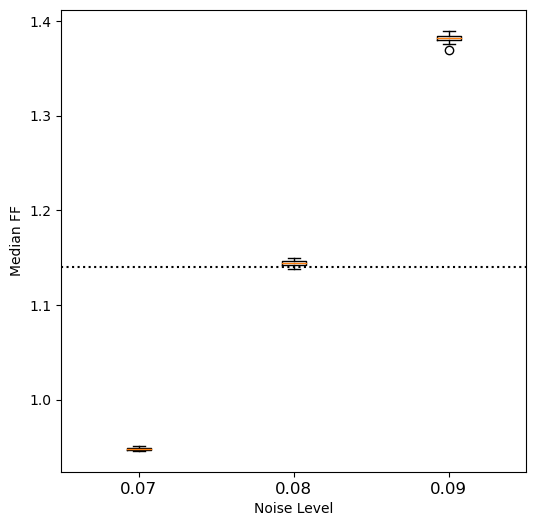

In [148]:
plt.figure(figsize=(6,6))
for b,noise_level in enumerate(recurrent_noise_range):
    plt.boxplot(medians_fef[noise_level], positions=[b])
plt.xticks(np.arange(len(recurrent_noise_range)), recurrent_noise_range, fontsize=12)
plt.xlabel("Noise Level")
plt.ylabel("Median FF")

plt.axhline(y = 1.14, color = 'black', linestyle = 'dotted')
plt.show()